## Depth integrated tracer on shelf per km along shelf, splitted into inner shelf and outer shelf

This notebooks looks at the **effect of the canyon** on upwelling the inner and outer shelves. Effect of the canyon is defined here as the residual between a run with a canyon bathymetry and one with a flat shelf.

In [1]:
#import gsw as sw # Gibbs seawater package

from math import *

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

%matplotlib inline

#from MITgcmutils import rdmds

from netCDF4 import Dataset

import numpy as np

import os 

import pandas as pd

import pylab as pl

import scipy.io

import scipy as spy

import seaborn as sns

import sys

In [2]:
lib_path = os.path.abspath('../../Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
#lib_path = os.path.abspath('../BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts

sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 
import MetricsPythonTools as mpt


In [3]:
sns.set()
sns.set_style('white')
sns.set_context('talk')

In [46]:
# plotting functions
def plotCanyonPos(ax,UpX,DnX):
    ax.axvline(UpX,color='0.70',linestyle='--')
    ax.axvline(DnX,color='0.70',linestyle='--')

def plotZeroLine(ax):
    ax.axhline(y=0,color='0.70',linestyle='-')
    


In [5]:
#Exp
CGrid = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/gridGlob.nc' 
CGridOut = Dataset(CGrid)

CGridNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/gridGlob.nc' 
CGridNoCOut = Dataset(CGridNoC)
#------------------------------------------------------------------------------------
Ptracers = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/ptracersGlob.nc' 
PtracersOut = Dataset(Ptracers)

PtracersNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/ptracersGlob.nc' #No canyon
PtracersOutNoC = Dataset(PtracersNoC)
#------------------------------------ Kv ----------------------------------------------
Ptracers11 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run11/ptracersGlob.nc' 
Ptracers12 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run12/ptracersGlob.nc' 

Ptracers24 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run24/ptracersGlob.nc' #No canyon
Ptracers25 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run25/ptracersGlob.nc' #No canyon
#----------------------------------- N -----------------------------------------------
Ptracers14 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run14/ptracersGlob.nc' 
Ptracers15 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run15/ptracersGlob.nc' 
Ptracers16 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run16/ptracersGlob.nc' 

Ptracers26 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run26/ptracersGlob.nc' #No canyon
Ptracers27 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run27/ptracersGlob.nc' #No canyon
Ptracers28 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run28/ptracersGlob.nc' #No canyon
#---------------------------------- f --------------------------------------------------
Ptracers18 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run18/ptracersGlob.nc' 
Ptracers19 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run19/ptracersGlob.nc' 

Ptracers22 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run22/ptracersGlob.nc' #No canyon
Ptracers23 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run23/ptracersGlob.nc' #No canyon
#---------------------------------- Kv 3D ----------------------------------------------
Ptracers043D = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run04/ptracersGlob.nc' 
Ptracers053D = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run05/ptracersGlob.nc' 
Ptracers063D = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run06/ptracersGlob.nc' 
Ptracers073D = '/ocean/kramosmu/MITgcm/TracerExperiments/3DDIFF/run07/ptracersGlob.nc' 


State = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run03/stateGlob.nc' 
StateNoC = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run07/stateGlob.nc' 



In [6]:
# General input

nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 
numTr = 22 # number of tracers in total (CNT =22, 3D = 4, total = 19)

rc = CGridNoCOut.variables['RC']
dxf = CGridNoCOut.variables['dxF']
xc = rout.getField(CGridNoC, 'XC') # x coords tracer cells
yc = rout.getField(CGridNoC, 'YC') # y coords tracer cells

rA = rout.getField(CGridNoC, 'rA') 
depth = rout.getField(CGrid, 'Depth')
drF = CGridNoCOut.variables['drF'] # vertical distance between faces
drC = CGridNoCOut.variables['drC'] # vertical distance between centers

hFacC = rout.getField(CGridNoC, 'HFacC')
mask_NoC = rout.getMask(CGridNoC, 'HFacC')


times = np.arange(0,nt,1)

#print(drC[:])
#print(np.shape(drC))

In [7]:
def HCW_Tracer_AlongShelf_Split(Tr,MaskC,nzlim,rA,hFacC,drF,yin,yfin,zfin,xi,yi):
  '''
  INPUT----------------------------------------------------------------------------------------------------------------
    Tr    : Array with concentration values for a tracer. Until this function is more general, this should be size 19x90x360x360
    MaskC : Land mask for tracer
    nzlim : The nz index under which to look for water properties
    rA    : Area of cell faces at C points (360x360)
    fFacC : Fraction of open cell (90x360x360)
    drF   : Distance between cell faces (90)
    yin   : first across-shore index of shelf division
    yfin  : final across-shore index of shelf division
    zfin  : shelf break index + 1 
    xi    : initial profile x index
    yi    : initial profile y index
    
    OUTPUT----------------------------------------------------------------------------------------------------------------
    VolWaterHighConc =  Array with the volume of water over the shelf [t,360] at every time output.
    Total_Tracer =  Array with the mass of tracer (m^3*[C]*l/m^3) at each x-position over the shelf [t,360] at 
                    every time output. 
                                                
  -----------------------------------------------------------------------------------------------------------------------
  '''
  maskExp = mpt.maskExpand(MaskC,Tr)

  TrMask=np.ma.array(Tr,mask=maskExp)   
    
  trlim = TrMask[0,nzlim,yi,xi]
    
  print('tracer limit concentration is: ',trlim)
    
    
  # mask cells with tracer concentration < trlim on shelf
  HighConc_Masked = np.ma.masked_less(TrMask[:,:zfin,yin:yfin,:], trlim) 
  HighConc_Mask = HighConc_Masked.mask
    
  #Get volume of water of cells with relatively high concentration
  rA_exp = np.expand_dims(rA[yin:yfin,:],0)
  drF_exp = np.expand_dims(np.expand_dims(drF[:zfin],1),1)
  rA_exp = rA_exp + np.zeros(hFacC[:zfin,yin:yfin,:].shape)
  drF_exp = drF_exp + np.zeros(hFacC[:zfin,yin:yfin,:].shape)
    
  ShelfVolume = hFacC[:zfin,yin:yfin,:]*drF_exp*rA_exp
  ShelfVolume_exp = np.expand_dims(ShelfVolume,0)
  ShelfVolume_exp = ShelfVolume_exp + np.zeros(HighConc_Mask.shape)
    
  HighConc_CellVol = np.ma.masked_array(ShelfVolume_exp,mask = HighConc_Mask) 
  VolWaterHighConc =np.ma.sum(np.ma.sum(HighConc_CellVol,axis = 1),axis=1)
    
   #Get total mass of tracer on shelf
  Total_Tracer = np.ma.sum(np.ma.sum(ShelfVolume_exp*TrMask[:,:zfin,yin:yfin,:]*1000.0,axis = 1),axis=1)
   # 1 m^3 = 1000 l
    
  return (VolWaterHighConc, Total_Tracer)

y index for shelfbreak, 100m depth and 50 m depth
depth[227,0] is 147.753973 
depth[267,0] is 100.000000 
depth[359,0] is 20.000000 


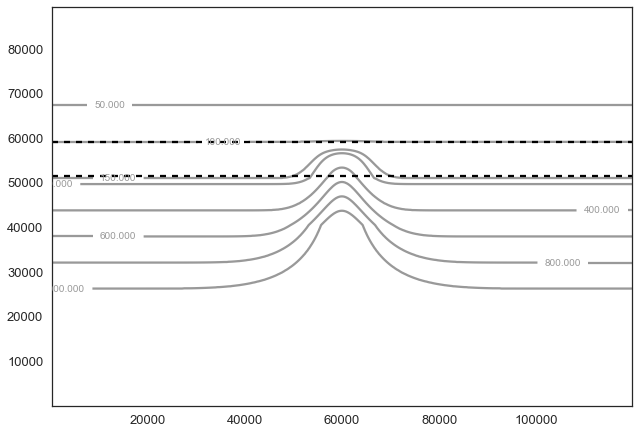

In [81]:
contour = plt.contour(xc[1,:],yc[:,1],depth,[50,100,150,200,400,600,800,1000,1200],colors='0.60')
plt.clabel(contour, inline=1, fontsize=10)
plt.axhline(yc[267,1],color='k',linestyle='--')
plt.axhline(yc[227,1],color='k',linestyle='--')

print('y index for shelfbreak, 100m depth and 50 m depth')
print('depth[227,0] is %f ' % depth[227,0])
print('depth[267,0] is %f ' % depth[267,0])
print('depth[359,0] is %f ' % depth[359,0])


In [9]:
Tr1 = rout.getField(Ptracers, 'Tr1')
Tr1NoC = rout.getField(PtracersNoC, 'Tr1')

## Changing Diffusivity

In [10]:
HCWout,TrMassout = HCW_Tracer_AlongShelf_Split(Tr1,mask_NoC,30,rA,hFacC,drF,227,267,30,180,50)
HCWin,TrMassin = HCW_Tracer_AlongShelf_Split(Tr1,mask_NoC,30,rA,hFacC,drF,267,359,30,180,50)

HCWNoCout,TrMassNoCout = HCW_Tracer_AlongShelf_Split(Tr1NoC,mask_NoC,30,rA,hFacC,drF,227,267,30,180,50)
HCWNoCin,TrMassNoCin = HCW_Tracer_AlongShelf_Split(Tr1NoC,mask_NoC,30,rA,hFacC,drF,267,359,30,180,50)



('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)


In [11]:
Tra = rout.getField(Ptracers11, 'Tr2')
Trb = rout.getField(Ptracers12, 'Tr3')

Trc = rout.getField(Ptracers24, 'Tr1')
Trd = rout.getField(Ptracers25, 'Tr1')

In [12]:
HCW11out,TrMass11out = HCW_Tracer_AlongShelf_Split(Tra,mask_NoC,30,rA,hFacC,drF,227,267,30,180,50)
HCW12out,TrMass12out = HCW_Tracer_AlongShelf_Split(Trb,mask_NoC,30,rA,hFacC,drF,227,267,30,180,50)

HCW11in,TrMass11in = HCW_Tracer_AlongShelf_Split(Tra,mask_NoC,30,rA,hFacC,drF,267,359,30,180,50)
HCW12in,TrMass12in = HCW_Tracer_AlongShelf_Split(Trb,mask_NoC,30,rA,hFacC,drF,267,359,30,180,50)

HCW24out,TrMass24out = HCW_Tracer_AlongShelf_Split(Trc,mask_NoC,30,rA,hFacC,drF,227,267,30,180,50)
HCW25out,TrMass25out = HCW_Tracer_AlongShelf_Split(Trd,mask_NoC,30,rA,hFacC,drF,227,267,30,180,50)

HCW24in,TrMass24in = HCW_Tracer_AlongShelf_Split(Trc,mask_NoC,30,rA,hFacC,drF,267,359,30,180,50)
HCW25in,TrMass25in = HCW_Tracer_AlongShelf_Split(Trd,mask_NoC,30,rA,hFacC,drF,267,359,30,180,50)


('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)


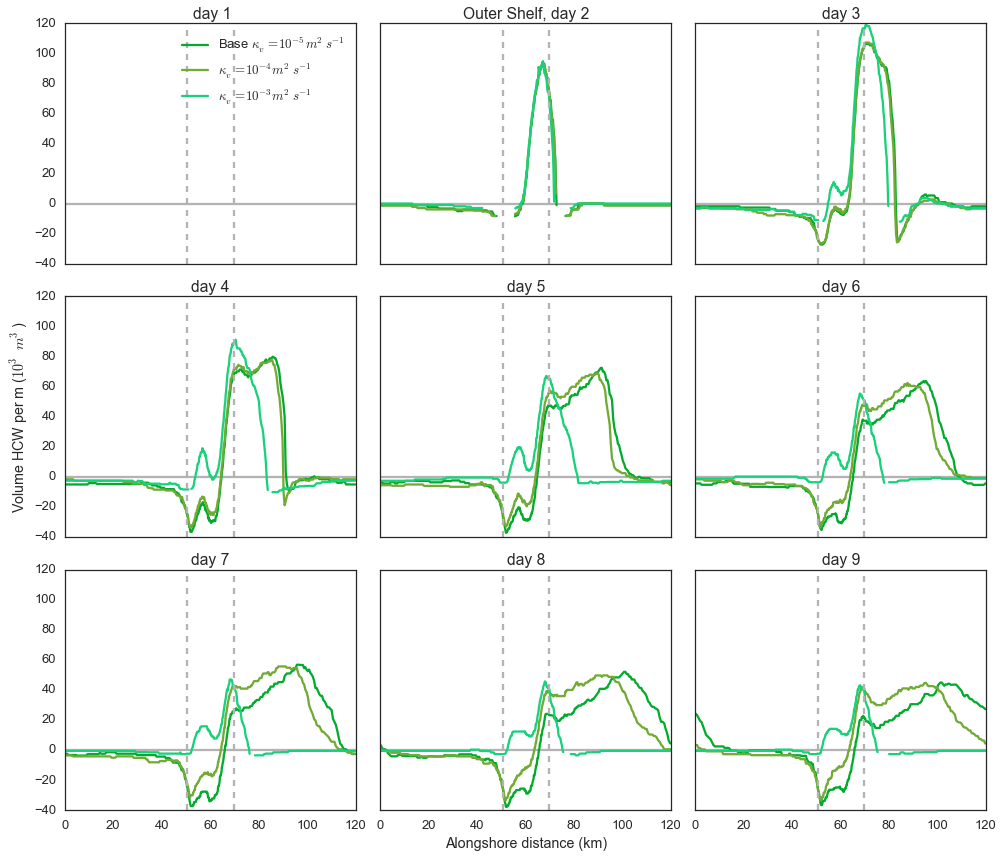

In [14]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3, figsize = (14,12),sharex=True, sharey=True)

axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

times = [2,4,6,8,10,12,14,16,18]
for ii,ax in zip(times,axlist):
    plotZeroLine(ax)
    ax.plot(xc[1,:]/1000,(HCWout[ii,:]-HCWNoCout[ii,:])/(1000*dxf[0,:]),sns.xkcd_rgb["kelly green"],label='Base $\kappa_v=10^{-5}m^2s^{-1}$')
    ax.plot(xc[1,:]/1000,(HCW11out[ii,:]-HCW24out[ii,:])/(1000*dxf[0,:]),sns.xkcd_rgb["leaf"],label='$\kappa_v=10^{-4}m^2s^{-1}$')
    ax.plot(xc[1,:]/1000,(HCW12out[ii,:]-HCW25out[ii,:])/(1000*dxf[0,:]),sns.xkcd_rgb["seaweed"],label='$\kappa_v=10^{-3}m^2s^{-1}$')
    
    ax.set_title('day %d' %(ii/2))
    plotCanyonPos(ax,xc[1,120]/1000,xc[1,240]/1000)

ax1.legend(loc=0)
ax8.set_xlabel('Alongshore distance (km)')
ax4.set_ylabel('Volume HCW per m ($10^3$ $m^3$)')
ax2.set_title('Outer Shelf, day 2')
    
plt.tight_layout()

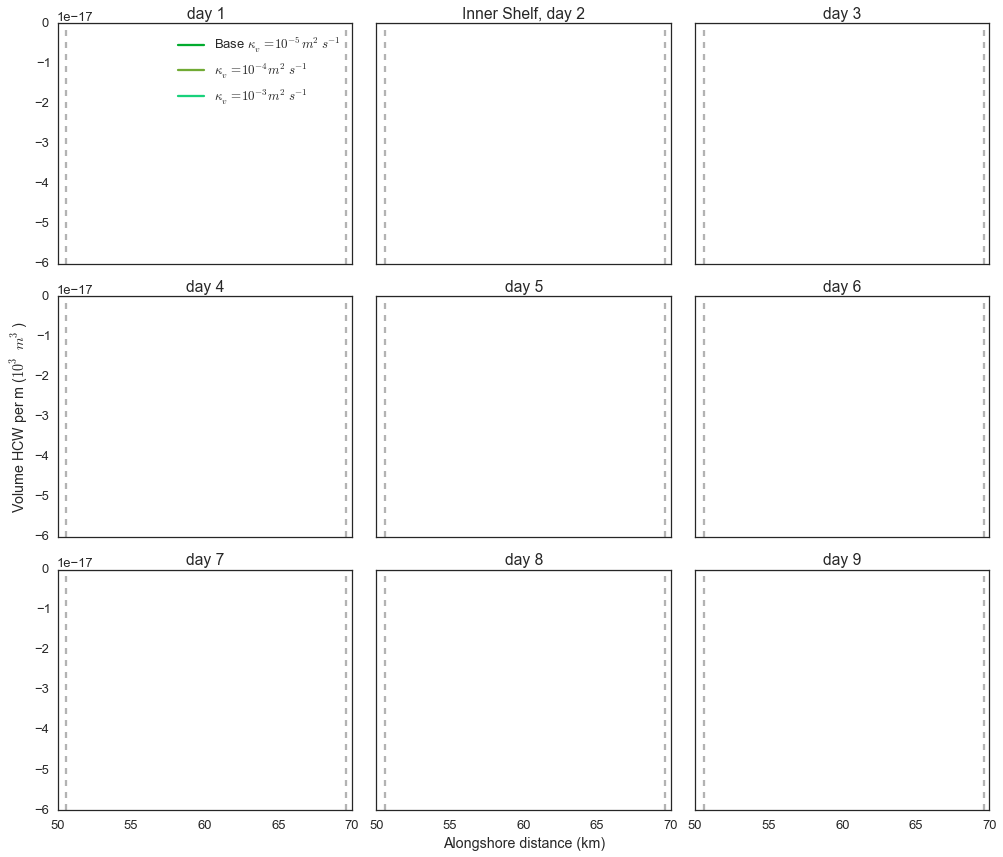

In [22]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3, figsize = (14,12),sharex=True, sharey=True)

axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

times = [2,4,6,8,10,12,14,16,18]
for ii,ax in zip(times,axlist):
    plotZeroLine(ax)
    ax.plot(xc[1,:]/1000,(HCWin[ii,:]-HCWNoCin[ii,:])/(1000*dxf[0,:]),sns.xkcd_rgb["kelly green"],label='Base $\kappa_v=10^{-5}m^2s^{-1}$')
    ax.plot(xc[1,:]/1000,(HCW11in[ii,:]-HCW24in[ii,:])/(1000*dxf[0,:]),sns.xkcd_rgb["leaf"],label='$\kappa_v=10^{-4}m^2s^{-1}$')
    ax.plot(xc[1,:]/1000,(HCW12in[ii,:]-HCW25in[ii,:])/(1000*dxf[0,:]),sns.xkcd_rgb["seaweed"],label='$\kappa_v=10^{-3}m^2s^{-1}$')
    
    
    ax.set_title('day %d' %(ii/2))
    plotCanyonPos(ax,xc[1,120]/1000,xc[1,240]/1000)

ax1.legend(loc=0)
ax8.set_xlabel('Alongshore distance (km)')
ax4.set_ylabel('Volume HCW per m ($10^3$ $m^3$)')
ax2.set_title('Inner Shelf, day 2')
    
plt.tight_layout()

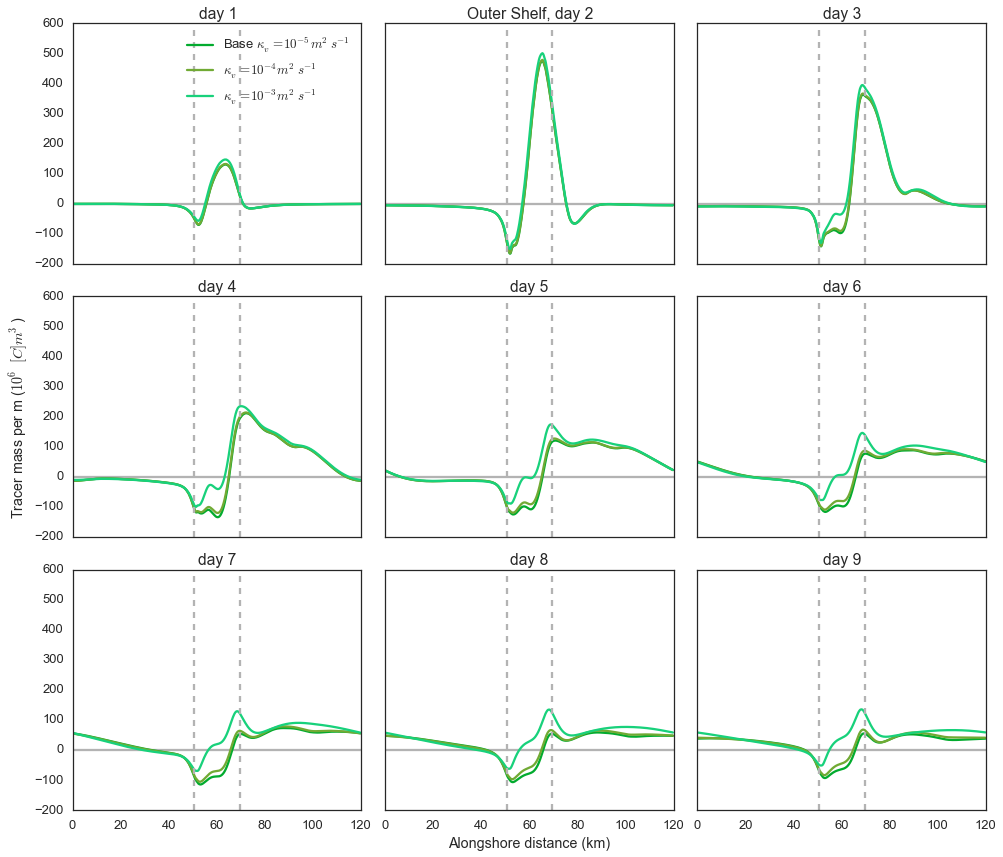

In [20]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3, figsize = (14,12),sharex=True, sharey=True)

axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

times = [2,4,6,8,10,12,14,16,18]
for ii,ax in zip(times,axlist):
    plotZeroLine(ax)
    ax.plot(xc[1,:]/1000,(TrMassout[ii,:]-TrMassNoCout[ii,:])/(1000000*dxf[0,:]),sns.xkcd_rgb["kelly green"],label='Base $\kappa_v=10^{-5}m^2s^{-1}$')
    ax.plot(xc[1,:]/1000,(TrMass11out[ii,:]-TrMass24out[ii,:])/(1000000*dxf[0,:]),sns.xkcd_rgb["leaf"],label='$\kappa_v=10^{-4}m^2s^{-1}$')
    ax.plot(xc[1,:]/1000,(TrMass12out[ii,:]-TrMass25out[ii,:])/(1000000*dxf[0,:]),sns.xkcd_rgb["seaweed"],label='$\kappa_v=10^{-3}m^2s^{-1}$')
    
    
    ax.set_title('day %d' %(ii/2))
    plotCanyonPos(ax,xc[1,120]/1000,xc[1,240]/1000)

ax1.legend(loc=0)
ax8.set_xlabel('Alongshore distance (km)')
ax4.set_ylabel('Tracer mass per m ($10^6$ $[C]m^3$)')
ax2.set_title('Outer Shelf, day 2')
plt.tight_layout()    


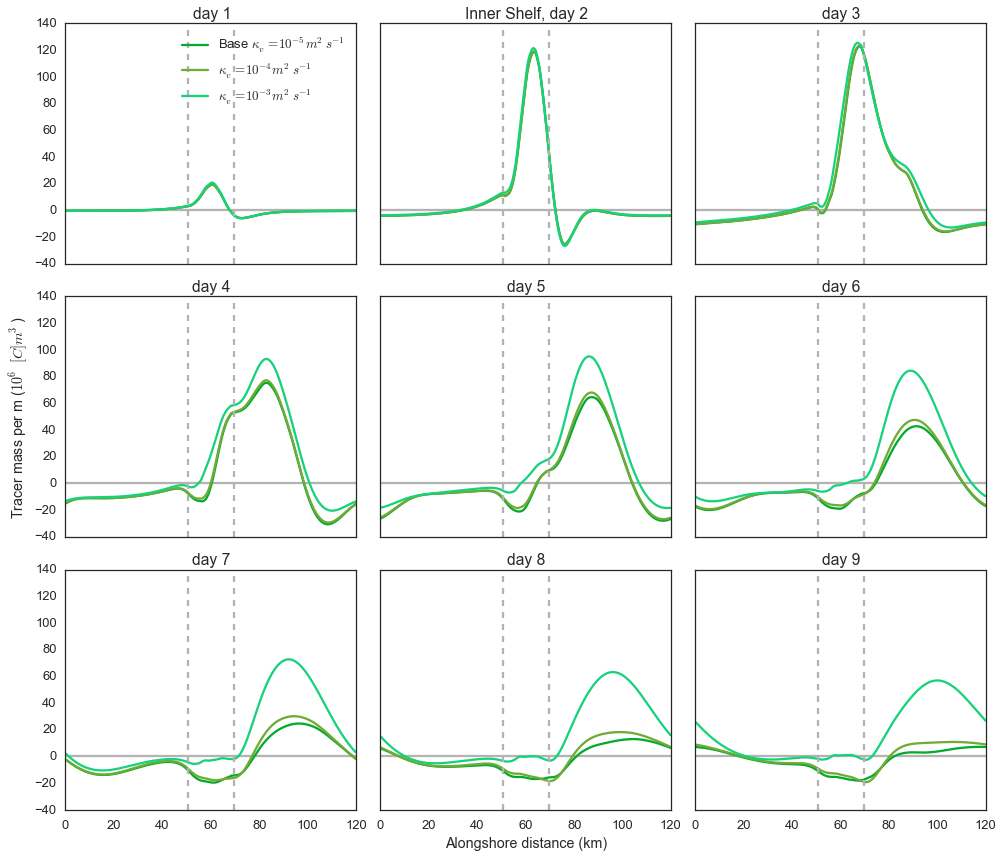

In [23]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3, figsize = (14,12),sharex=True, sharey=True)

axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

times = [2,4,6,8,10,12,14,16,18]
for ii,ax in zip(times,axlist):
    plotZeroLine(ax)
    ax.plot(xc[1,:]/1000,(TrMassin[ii,:]-TrMassNoCin[ii,:])/(1000000*dxf[0,:]),sns.xkcd_rgb["kelly green"],label='Base $\kappa_v=10^{-5}m^2s^{-1}$')
    ax.plot(xc[1,:]/1000,(TrMass11in[ii,:]-TrMass24in[ii,:])/(1000000*dxf[0,:]),sns.xkcd_rgb["leaf"],label='$\kappa_v=10^{-4}m^2s^{-1}$')
    ax.plot(xc[1,:]/1000,(TrMass12in[ii,:]-TrMass25in[ii,:])/(1000000*dxf[0,:]),sns.xkcd_rgb["seaweed"],label='$\kappa_v=10^{-3}m^2s^{-1}$')
    
    
    ax.set_title('day %d' %(ii/2))
    plotCanyonPos(ax,xc[1,120]/1000,xc[1,240]/1000)

ax1.legend(loc=0)
ax8.set_xlabel('Alongshore distance (km)')
ax4.set_ylabel('Tracer mass per m ($10^6$ $[C]m^3$)')
ax2.set_title('Inner Shelf, day 2')
plt.tight_layout()    


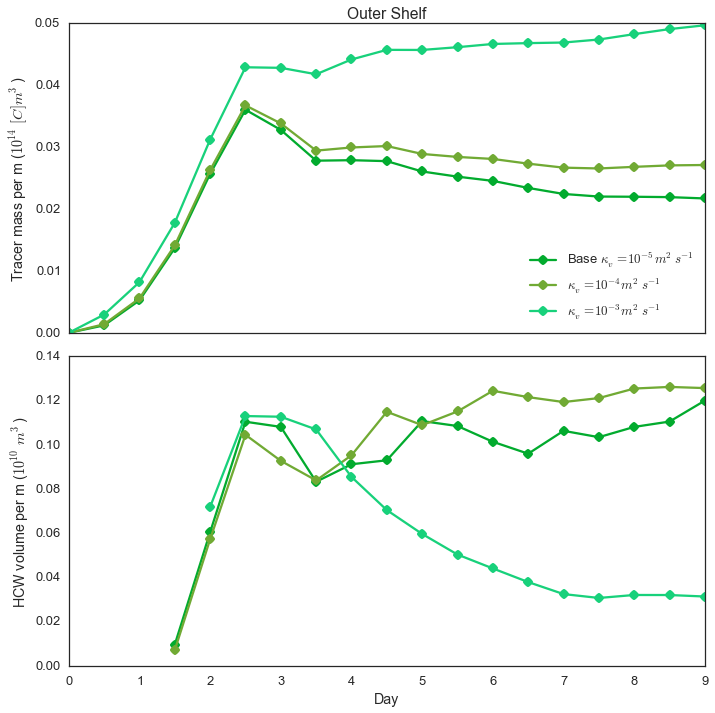

In [25]:
fig,(ax1,ax2) = plt.subplots(2,1, figsize = (10,10),sharex=True)

tt = np.arange(19)

ax1.plot(tt/2.,np.sum((TrMassout-TrMassNoCout),axis=1)/1.E14,sns.xkcd_rgb["kelly green"],marker = 'o',label='Base $\kappa_v=10^{-5}m^2s^{-1}$')
ax1.plot(tt/2.,np.sum((TrMass11out-TrMass24out),axis=1)/1.E14,sns.xkcd_rgb["leaf"],marker = 'o',label='$\kappa_v=10^{-4}m^2s^{-1}$')
ax1.plot(tt/2.,np.sum((TrMass12out-TrMass25out),axis=1)/1.E14,sns.xkcd_rgb["seaweed"],marker = 'o',label='$\kappa_v=10^{-3}m^2s^{-1}$')
   
ax2.plot(tt/2.,np.sum(HCWout-HCWNoCout,axis=1)/1.E10,sns.xkcd_rgb["kelly green"],marker = 'o',label='Base $\kappa_v=10^{-5}m^2s^{-1}$')
ax2.plot(tt/2.,np.sum(HCW11out-HCW24out,axis=1)/1.E10,sns.xkcd_rgb["leaf"],marker = 'o',label='$\kappa_v=10^{-4}m^2s^{-1}$')
ax2.plot(tt/2.,np.sum(HCW12out-HCW25out,axis=1)/1.E10,sns.xkcd_rgb["seaweed"],marker = 'o',label='$\kappa_v=10^{-3}m^2s^{-1}$')
  
    
ax1.legend(loc=0)
ax2.set_xlabel('Day')
ax1.set_ylabel('Tracer mass per m ($10^{14}$ $[C]m^3$)')
ax2.set_ylabel('HCW volume per m ($10^{10}$ $m^3$)')
ax1.set_title('Outer Shelf')
plt.tight_layout()

plt.show()



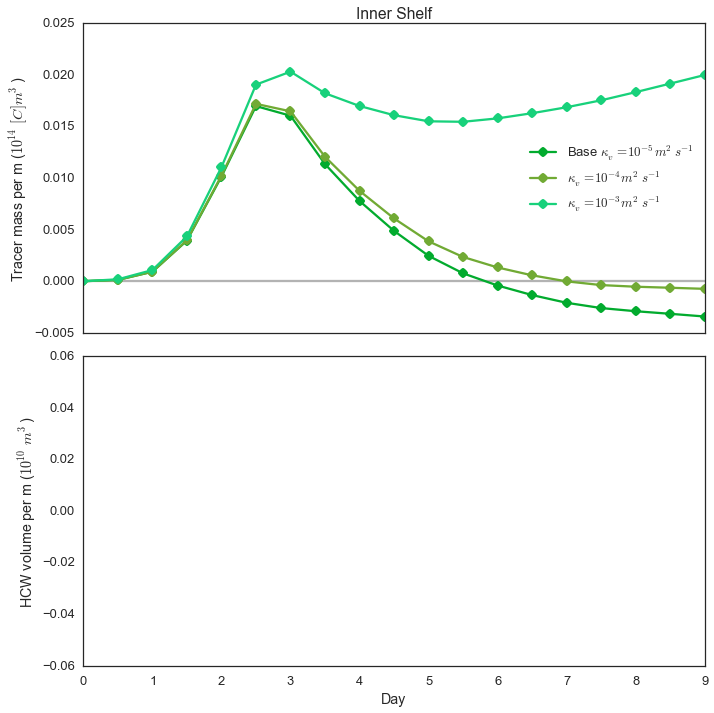

In [77]:
fig,(ax1,ax2) = plt.subplots(2,1, figsize = (10,10),sharex=True)

tt = np.arange(19)
plotZeroLine(ax1)
ax1.plot(tt/2.,np.sum(TrMassin-TrMassNoCin,axis=1)/1.E14,sns.xkcd_rgb["kelly green"],marker = 'o',label='Base $\kappa_v=10^{-5}m^2s^{-1}$')
ax1.plot(tt/2.,np.sum(TrMass11in-TrMass24in,axis=1)/1.E14,sns.xkcd_rgb["leaf"],marker = 'o',label='$\kappa_v=10^{-4}m^2s^{-1}$')
ax1.plot(tt/2.,np.sum(TrMass12in-TrMass25in,axis=1)/1.E14,sns.xkcd_rgb["seaweed"],marker = 'o',label='$\kappa_v=10^{-3}m^2s^{-1}$')
   
ax2.plot(tt/2.,np.sum(HCWin-HCWNoCin,axis=1)/1.E10,sns.xkcd_rgb["kelly green"],marker = 'o',label='Base $\kappa_v=10^{-5}m^2s^{-1}$')
ax2.plot(tt/2.,np.sum(HCW11in-HCW24in,axis=1)/1.E10,sns.xkcd_rgb["leaf"],marker = 'o',label='$\kappa_v=10^{-4}m^2s^{-1}$')
ax2.plot(tt/2.,np.sum(HCW12in-HCW25in,axis=1)/1.E10,sns.xkcd_rgb["seaweed"],marker = 'o',label='$\kappa_v=10^{-3}m^2s^{-1}$')
  
    
ax1.legend(loc=0)
ax2.set_xlabel('Day')
ax1.set_ylabel('Tracer mass per m ($10^{14}$ $[C]m^3$)')
ax2.set_ylabel('HCW volume per m ($10^{10}$ $m^3$)')
ax1.set_title('Inner Shelf')
plt.tight_layout()

plt.show()



## Changing geography of diapycnal diffusivity 

In [28]:
#Tra = rout.getField(Ptracers043D, 'Tr1')
#Trb = rout.getField(Ptracers053D, 'Tr1')
Trc = rout.getField(Ptracers063D, 'Tr1')
Trd = rout.getField(Ptracers073D, 'Tr1')

In [29]:
#HCW043Dout,TrMass043Dout = HCW_Tracer_AlongShelf_Split(Tra,mask_NoC,30,rA,hFacC,drF,227,267,30,180,50)
#HCW053Dout,TrMass053Dout = HCW_Tracer_AlongShelf_Split(Trb,mask_NoC,30,rA,hFacC,drF,227,267,30,180,50)
HCW063Dout,TrMass063Dout = HCW_Tracer_AlongShelf_Split(Trc,mask_NoC,30,rA,hFacC,drF,227,267,30,180,50)
HCW073Dout,TrMass073Dout = HCW_Tracer_AlongShelf_Split(Trd,mask_NoC,30,rA,hFacC,drF,227,267,30,180,50)

#HCW043Din,TrMass043Din = HCW_Tracer_AlongShelf_Split(Tra,mask_NoC,30,rA,hFacC,drF,267,359,30,180,50)
#HCW053Din,TrMass053Din = HCW_Tracer_AlongShelf_Split(Trb,mask_NoC,30,rA,hFacC,drF,267,359,30,180,50)
HCW063Din,TrMass063Din = HCW_Tracer_AlongShelf_Split(Trc,mask_NoC,30,rA,hFacC,drF,267,359,30,180,50)
HCW073Din,TrMass073Din = HCW_Tracer_AlongShelf_Split(Trd,mask_NoC,30,rA,hFacC,drF,267,359,30,180,50)

('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)


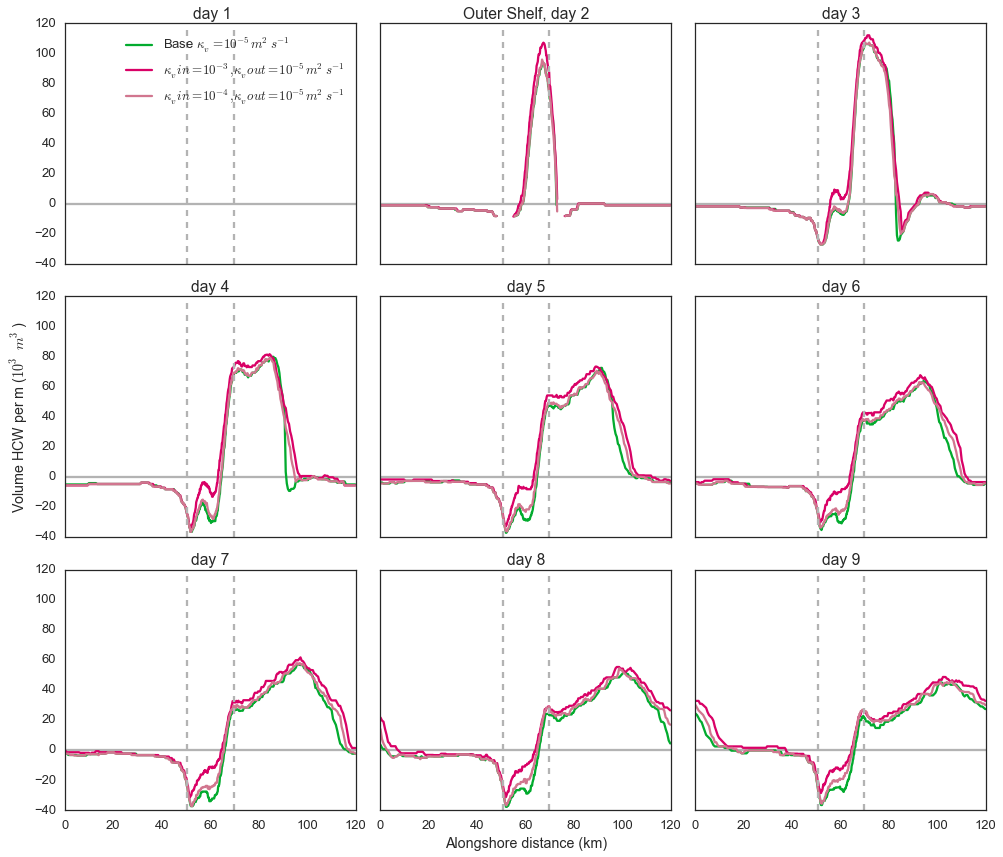

In [30]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3, figsize = (14,12),sharex=True, sharey=True)

axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

times = [2,4,6,8,10,12,14,16,18]
for ii,ax in zip(times,axlist):
    plotZeroLine(ax)
    ax.plot(xc[1,:]/1000,(HCWout[ii,:]-HCWNoCout[ii,:])/(1000*dxf[0,:]),sns.xkcd_rgb["kelly green"],label='Base $\kappa_v=10^{-5}m^2s^{-1}$')
    ax.plot(xc[1,:]/1000,(HCW063Dout[ii,:]-HCWNoCout[ii,:])/(1000*dxf[0,:]),sns.xkcd_rgb["dark hot pink"],label='$\kappa_vin=10^{-3},\kappa_vout=10^{-5}m^2s^{-1}$')
    ax.plot(xc[1,:]/1000,(HCW073Dout[ii,:]-HCWNoCout[ii,:])/(1000*dxf[0,:]),sns.xkcd_rgb["muted pink"],label='$\kappa_vin=10^{-4},\kappa_vout=10^{-5}m^2s^{-1}$')
    
    
    ax.set_title('day %d' %(ii/2))
    plotCanyonPos(ax,xc[1,120]/1000,xc[1,240]/1000)

ax1.legend(loc=0)
ax8.set_xlabel('Alongshore distance (km)')
ax4.set_ylabel('Volume HCW per m ($10^3$ $m^3$)')
ax2.set_title('Outer Shelf, day 2')
plt.tight_layout()    


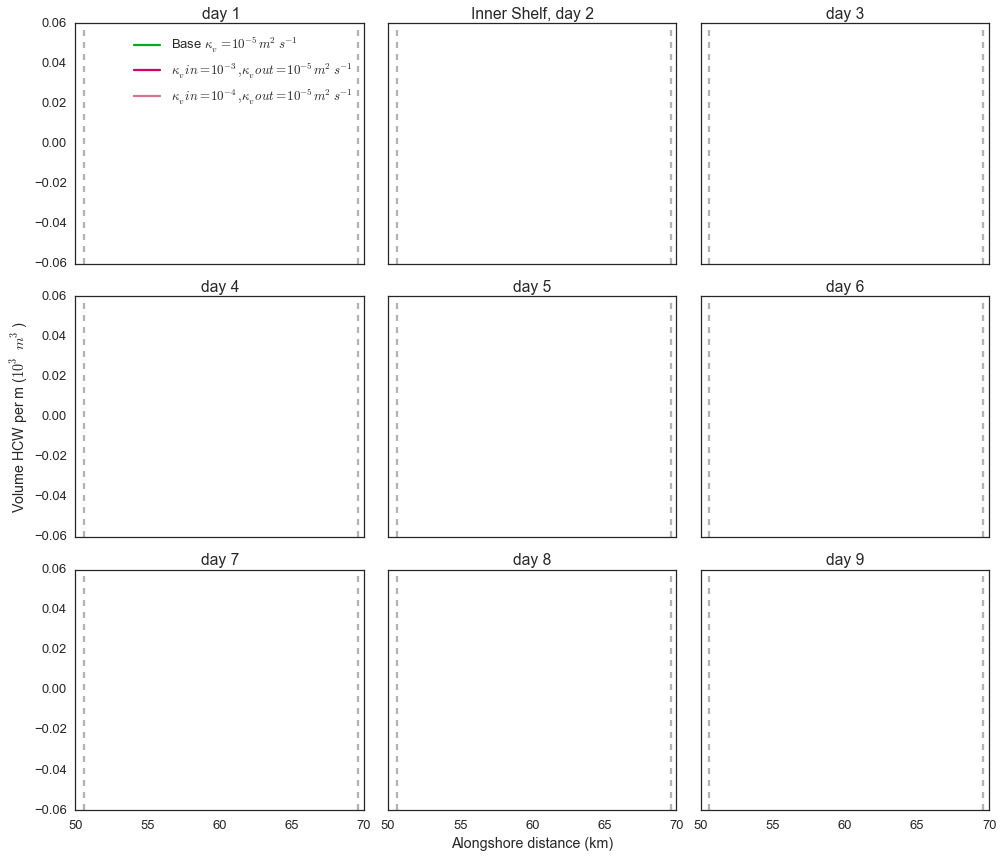

In [32]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3, figsize = (14,12),sharex=True, sharey=True)

axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

times = [2,4,6,8,10,12,14,16,18]
for ii,ax in zip(times,axlist):
    plotZeroLine(ax)
    ax.plot(xc[1,:]/1000,(HCWin[ii,:]-HCWNoCin[ii,:])/(1000*dxf[0,:]),sns.xkcd_rgb["kelly green"],label='Base $\kappa_v=10^{-5}m^2s^{-1}$')
    ax.plot(xc[1,:]/1000,(HCW063Din[ii,:]-HCWNoCin[ii,:])/(1000*dxf[0,:]),sns.xkcd_rgb["dark hot pink"],label='$\kappa_vin=10^{-3},\kappa_vout=10^{-5}m^2s^{-1}$')
    ax.plot(xc[1,:]/1000,(HCW073Din[ii,:]-HCWNoCin[ii,:])/(1000*dxf[0,:]),sns.xkcd_rgb["muted pink"],label='$\kappa_vin=10^{-4},\kappa_vout=10^{-5}m^2s^{-1}$')
    
    
    ax.set_title('day %d' %(ii/2))
    plotCanyonPos(ax,xc[1,120]/1000,xc[1,240]/1000)

ax1.legend(loc=0)
ax8.set_xlabel('Alongshore distance (km)')
ax4.set_ylabel('Volume HCW per m ($10^3$ $m^3$)')
ax2.set_title('Inner Shelf, day 2')
plt.tight_layout()    


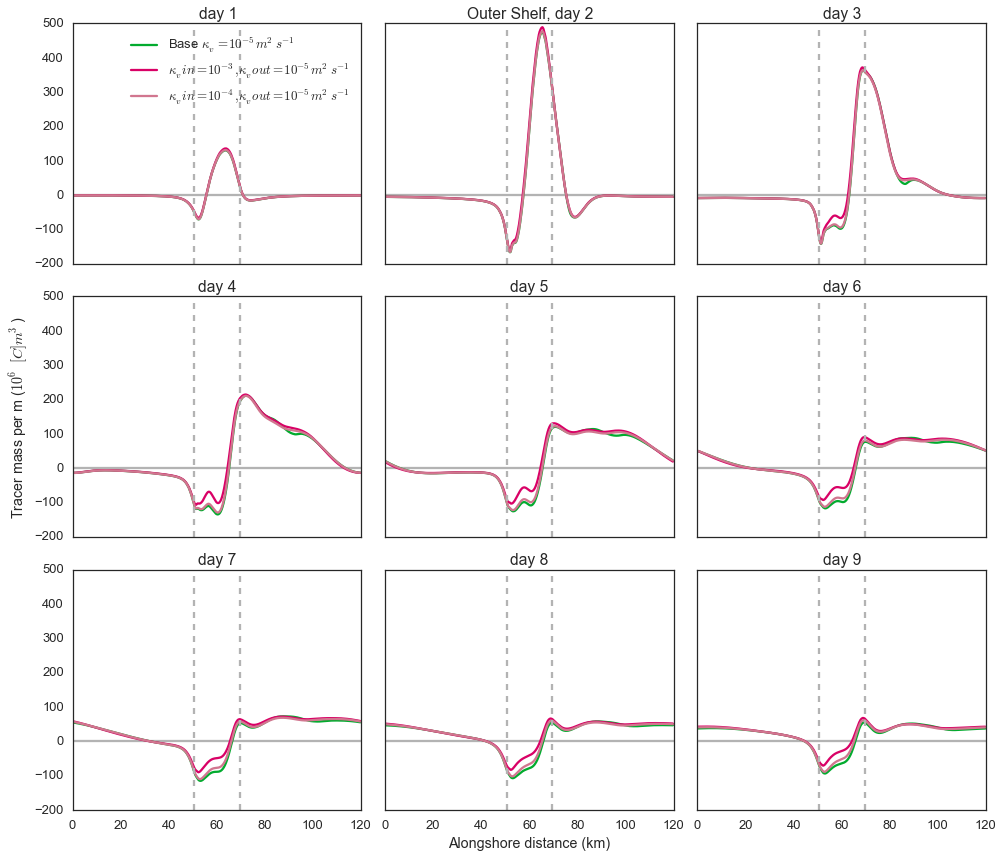

In [34]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3, figsize = (14,12),sharex=True, sharey=True)

axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

times = [2,4,6,8,10,12,14,16,18]
for ii,ax in zip(times,axlist):
    plotZeroLine(ax)
    ax.plot(xc[1,:]/1000,(TrMassout[ii,:]-TrMassNoCout[ii,:])/(1000000*dxf[0,:]),sns.xkcd_rgb["kelly green"],label='Base $\kappa_v=10^{-5}m^2s^{-1}$')
    ax.plot(xc[1,:]/1000,(TrMass063Dout[ii,:]-TrMassNoCout[ii,:])/(1000000*dxf[0,:]),sns.xkcd_rgb["dark hot pink"],label='$\kappa_vin=10^{-3},\kappa_vout=10^{-5}m^2s^{-1}$')
    ax.plot(xc[1,:]/1000,(TrMass073Dout[ii,:]-TrMassNoCout[ii,:])/(1000000*dxf[0,:]),sns.xkcd_rgb["muted pink"],label='$\kappa_vin=10^{-4},\kappa_vout=10^{-5}m^2s^{-1}$')
    
    
    ax.set_title('day %d' %(ii/2))
    plotCanyonPos(ax,xc[1,120]/1000,xc[1,240]/1000)

ax1.legend(loc=0)
ax8.set_xlabel('Alongshore distance (km)')
ax4.set_ylabel('Tracer mass per m ($10^6$ $[C]m^3$)')
ax2.set_title('Outer Shelf, day 2')
    
plt.tight_layout()

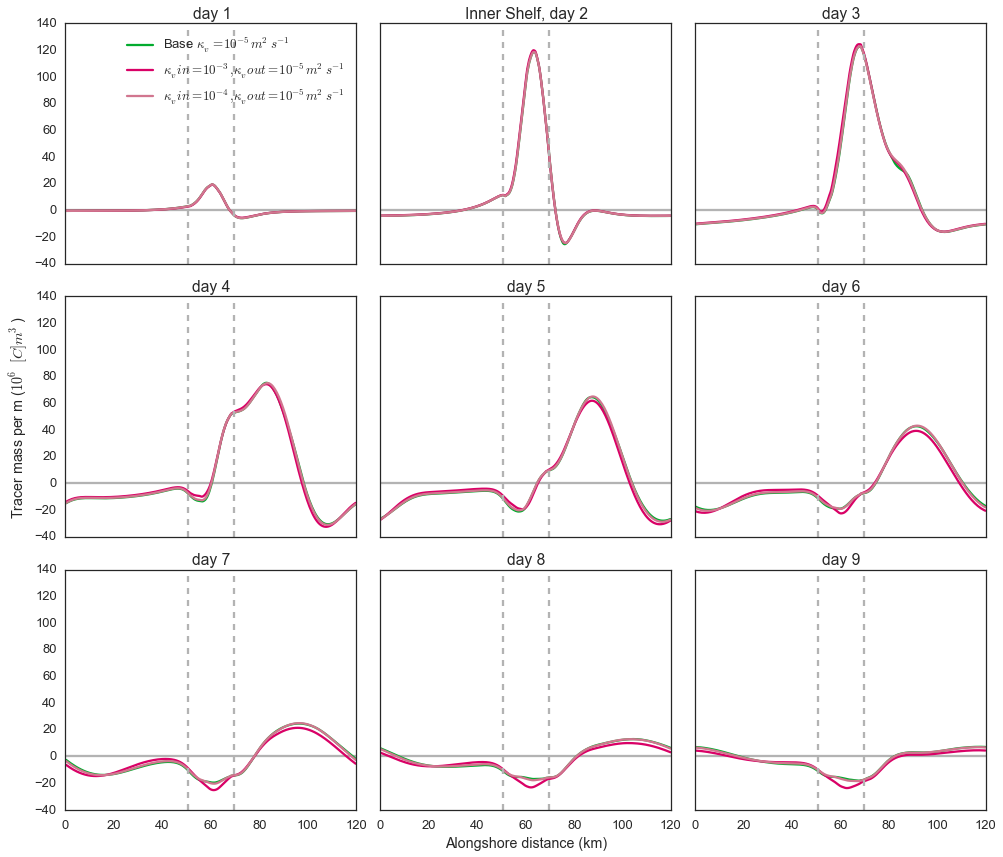

In [36]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3, figsize = (14,12),sharex=True, sharey=True)

axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

times = [2,4,6,8,10,12,14,16,18]
for ii,ax in zip(times,axlist):
    plotZeroLine(ax)
    ax.plot(xc[1,:]/1000,(TrMassin[ii,:]-TrMassNoCin[ii,:])/(1000000*dxf[0,:]),sns.xkcd_rgb["kelly green"],label='Base $\kappa_v=10^{-5}m^2s^{-1}$')
    ax.plot(xc[1,:]/1000,(TrMass063Din[ii,:]-TrMassNoCin[ii,:])/(1000000*dxf[0,:]),sns.xkcd_rgb["dark hot pink"],label='$\kappa_vin=10^{-3},\kappa_vout=10^{-5}m^2s^{-1}$')
    ax.plot(xc[1,:]/1000,(TrMass073Din[ii,:]-TrMassNoCin[ii,:])/(1000000*dxf[0,:]),sns.xkcd_rgb["muted pink"],label='$\kappa_vin=10^{-4},\kappa_vout=10^{-5}m^2s^{-1}$')
    
    
    ax.set_title('day %d' %(ii/2))
    plotCanyonPos(ax,xc[1,120]/1000,xc[1,240]/1000)

ax1.legend(loc=0)
ax8.set_xlabel('Alongshore distance (km)')
ax4.set_ylabel('Tracer mass per m ($10^6$ $[C]m^3$)')
ax2.set_title('Inner Shelf, day 2')
    
plt.tight_layout()

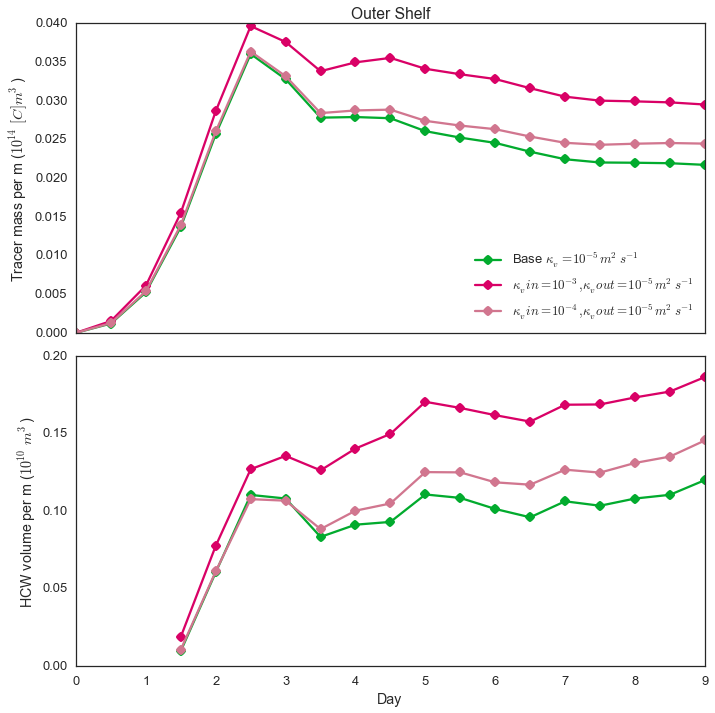

In [38]:
fig,(ax1,ax2) = plt.subplots(2,1, figsize = (10,10),sharex=True)

tt = np.arange(19)

ax1.plot(tt/2.,np.sum(TrMassout-TrMassNoCout,axis=1)/1.E14,sns.xkcd_rgb["kelly green"],marker = 'o',label='Base $\kappa_v=10^{-5}m^2s^{-1}$')
ax1.plot(tt/2.,np.sum(TrMass063Dout-TrMassNoCout,axis=1)/1.E14,sns.xkcd_rgb["dark hot pink"],marker = 'o',label='$\kappa_vin=10^{-3},\kappa_vout=10^{-5}m^2s^{-1}$')
ax1.plot(tt/2.,np.sum(TrMass073Dout-TrMassNoCout,axis=1)/1.E14,sns.xkcd_rgb["muted pink"],marker = 'o',label='$\kappa_vin=10^{-4},\kappa_vout=10^{-5}m^2s^{-1}$')
   
ax2.plot(tt/2.,np.sum(HCWout-HCWNoCout,axis=1)/1.E10,sns.xkcd_rgb["kelly green"],marker = 'o',label='Base $\kappa_v=10^{-5}m^2s^{-1}$')
ax2.plot(tt/2.,np.sum(HCW063Dout-HCWNoCout,axis=1)/1.E10,sns.xkcd_rgb["dark hot pink"],marker = 'o',label='$\kappa_vin=10^{-3},\kappa_vout=10^{-5}m^2s^{-1}$')
ax2.plot(tt/2.,np.sum(HCW073Dout-HCWNoCout,axis=1)/1.E10,sns.xkcd_rgb["muted pink"],marker = 'o',label='$\kappa_vin=10^{-4},\kappa_vout=10^{-5}m^2s^{-1}$')
  
    
ax1.legend(loc=0)
ax2.set_xlabel('Day')
ax1.set_ylabel('Tracer mass per m ($10^{14}$ $[C]m^3$)')
ax2.set_ylabel('HCW volume per m ($10^{10}$ $m^3$)')
ax1.set_title('Outer Shelf')
plt.tight_layout()

plt.show()



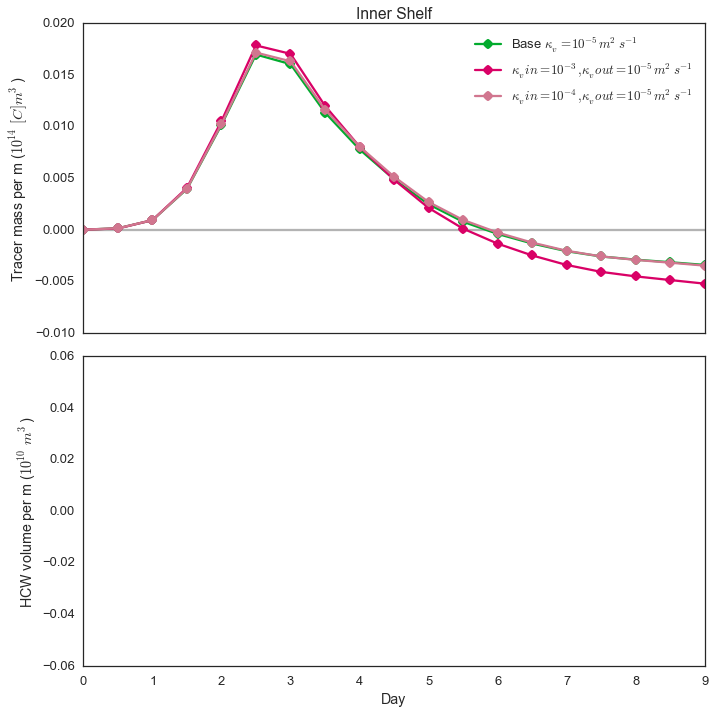

In [76]:
fig,(ax1,ax2) = plt.subplots(2,1, figsize = (10,10),sharex=True)

tt = np.arange(19)
plotZeroLine(ax1)
ax1.plot(tt/2.,np.sum(TrMassin-TrMassNoCin,axis=1)/1.E14,sns.xkcd_rgb["kelly green"],marker = 'o',label='Base $\kappa_v=10^{-5}m^2s^{-1}$')
ax1.plot(tt/2.,np.sum(TrMass063Din-TrMassNoCin,axis=1)/1.E14,sns.xkcd_rgb["dark hot pink"],marker = 'o',label='$\kappa_vin=10^{-3},\kappa_vout=10^{-5}m^2s^{-1}$')
ax1.plot(tt/2.,np.sum(TrMass073Din-TrMassNoCin,axis=1)/1.E14,sns.xkcd_rgb["muted pink"],marker = 'o',label='$\kappa_vin=10^{-4},\kappa_vout=10^{-5}m^2s^{-1}$')
   
ax2.plot(tt/2.,np.sum(HCWin-HCWNoCin,axis=1)/1.E10,sns.xkcd_rgb["kelly green"],marker = 'o',label='Base $\kappa_v=10^{-5}m^2s^{-1}$')
ax2.plot(tt/2.,np.sum(HCW063Din-HCWNoCin,axis=1)/1.E10,sns.xkcd_rgb["dark hot pink"],marker = 'o',label='$\kappa_vin=10^{-3},\kappa_vout=10^{-5}m^2s^{-1}$')
ax2.plot(tt/2.,np.sum(HCW073Din-HCWNoCin,axis=1)/1.E10,sns.xkcd_rgb["muted pink"],marker = 'o',label='$\kappa_vin=10^{-4},\kappa_vout=10^{-5}m^2s^{-1}$')
  
    
ax1.legend(loc=0)
ax2.set_xlabel('Day')
ax1.set_ylabel('Tracer mass per m ($10^{14}$ $[C]m^3$)')
ax2.set_ylabel('HCW volume per m ($10^{10}$ $m^3$)')
ax1.set_title('Inner Shelf')
plt.tight_layout()

plt.show()


## Changing initial stratification

In [40]:
Tra = rout.getField(Ptracers14, 'Tr1')
Trb = rout.getField(Ptracers15, 'Tr1')
Trc = rout.getField(Ptracers16, 'Tr1')

Trd = rout.getField(Ptracers26, 'Tr1')
Tre = rout.getField(Ptracers27, 'Tr1')
Trf = rout.getField(Ptracers28, 'Tr1')


In [43]:
HCW14out,TrMass14out = HCW_Tracer_AlongShelf_Split(Tra,mask_NoC,30,rA,hFacC,drF,227,267,30,180,50)
HCW15out,TrMass15out = HCW_Tracer_AlongShelf_Split(Trb,mask_NoC,30,rA,hFacC,drF,227,267,30,180,50)
HCW16out,TrMass16out = HCW_Tracer_AlongShelf_Split(Trc,mask_NoC,30,rA,hFacC,drF,227,267,30,180,50)

HCW26out,TrMass26out = HCW_Tracer_AlongShelf_Split(Trd,mask_NoC,30,rA,hFacC,drF,227,267,30,180,50)
HCW27out,TrMass27out = HCW_Tracer_AlongShelf_Split(Tre,mask_NoC,30,rA,hFacC,drF,227,267,30,180,50)
HCW28out,TrMass28out = HCW_Tracer_AlongShelf_Split(Trf,mask_NoC,30,rA,hFacC,drF,227,267,30,180,50)

HCW14in,TrMass14in = HCW_Tracer_AlongShelf_Split(Tra,mask_NoC,30,rA,hFacC,drF,267,359,30,180,50)
HCW15in,TrMass15in = HCW_Tracer_AlongShelf_Split(Trb,mask_NoC,30,rA,hFacC,drF,267,359,30,180,50)
HCW16in,TrMass16in = HCW_Tracer_AlongShelf_Split(Trc,mask_NoC,30,rA,hFacC,drF,267,359,30,180,50)

HCW26in,TrMass26in = HCW_Tracer_AlongShelf_Split(Trd,mask_NoC,30,rA,hFacC,drF,267,359,30,180,50)
HCW27in,TrMass27in = HCW_Tracer_AlongShelf_Split(Tre,mask_NoC,30,rA,hFacC,drF,267,359,30,180,50)
HCW28in,TrMass28in = HCW_Tracer_AlongShelf_Split(Trf,mask_NoC,30,rA,hFacC,drF,267,359,30,180,50)


('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)


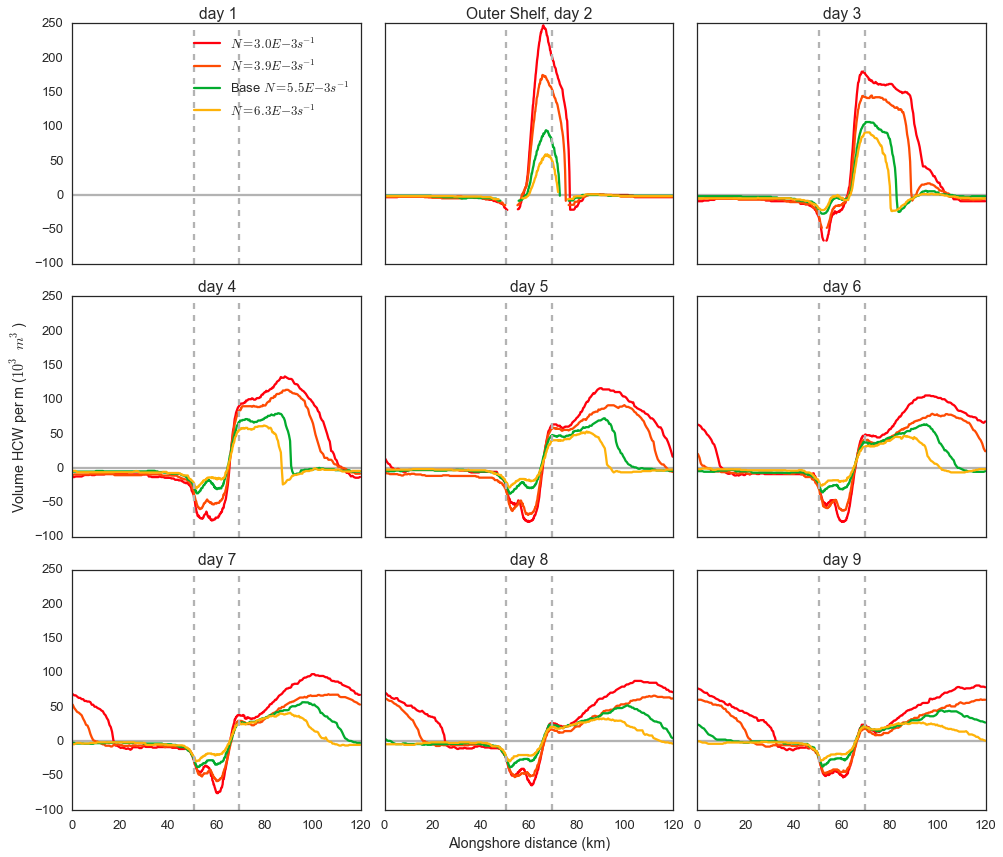

In [45]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3, figsize = (14,12),sharex=True, sharey=True)

axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

times = [2,4,6,8,10,12,14,16,18]
for ii,ax in zip(times,axlist):
    plotZeroLine(ax)
    ax.plot(xc[1,:]/1000,(HCW16out[ii,:]-HCW28out[ii,:])/(1000*dxf[0,:]),sns.xkcd_rgb["bright red"],label='$N=3.0E-3s^{-1}$')
    ax.plot(xc[1,:]/1000,(HCW14out[ii,:]-HCW26out[ii,:])/(1000*dxf[0,:]),sns.xkcd_rgb["blood orange"],label='$N=3.9E-3s^{-1}$')
    ax.plot(xc[1,:]/1000,(HCWout[ii,:]-HCWNoCout[ii,:])/(1000*dxf[0,:]),sns.xkcd_rgb["kelly green"],label='Base $N=5.5E-3s^{-1}$')
    ax.plot(xc[1,:]/1000,(HCW15out[ii,:]-HCW27out[ii,:])/(1000*dxf[0,:]),sns.xkcd_rgb["saffron"],label='$N=6.3E-3s^{-1}$')
    
    
    ax.set_title('day %d' %(ii/2))
    plotCanyonPos(ax,xc[1,120]/1000,xc[1,240]/1000)

ax1.legend(loc=0)
ax8.set_xlabel('Alongshore distance (km)')
ax4.set_ylabel('Volume HCW per m ($10^3$ $m^3$)')
ax2.set_title('Outer Shelf, day 2')
plt.tight_layout()


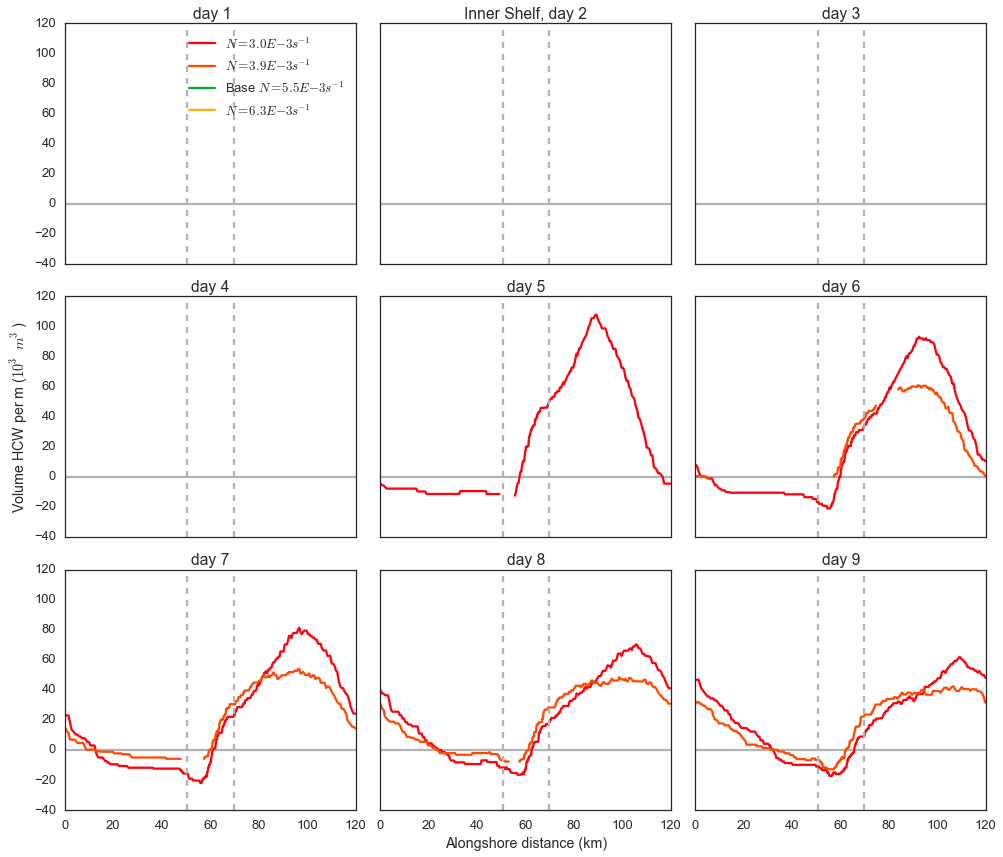

In [51]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3, figsize = (14,12),sharex=True, sharey=True)

axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

times = [2,4,6,8,10,12,14,16,18]
for ii,ax in zip(times,axlist):
    plotZeroLine(ax)
    ax.plot(xc[1,:]/1000,(HCW16in[ii,:]-HCW28in[ii,:])/(1000*dxf[0,:]),sns.xkcd_rgb["bright red"],label='$N=3.0E-3s^{-1}$')
    ax.plot(xc[1,:]/1000,(HCW14in[ii,:]-HCW26in[ii,:])/(1000*dxf[0,:]),sns.xkcd_rgb["blood orange"],label='$N=3.9E-3s^{-1}$')
    ax.plot(xc[1,:]/1000,(HCWin[ii,:]-HCWNoCin[ii,:])/(1000*dxf[0,:]),sns.xkcd_rgb["kelly green"],label='Base $N=5.5E-3s^{-1}$')
    ax.plot(xc[1,:]/1000,(HCW15in[ii,:]-HCW27in[ii,:])/(1000*dxf[0,:]),sns.xkcd_rgb["saffron"],label='$N=6.3E-3s^{-1}$')
    
    
    ax.set_title('day %d' %(ii/2))
    plotCanyonPos(ax,xc[1,120]/1000,xc[1,240]/1000)

ax1.legend(loc=0)
ax8.set_xlabel('Alongshore distance (km)')
ax4.set_ylabel('Volume HCW per m ($10^3$ $m^3$)')
ax2.set_title('Inner Shelf, day 2')
plt.tight_layout()


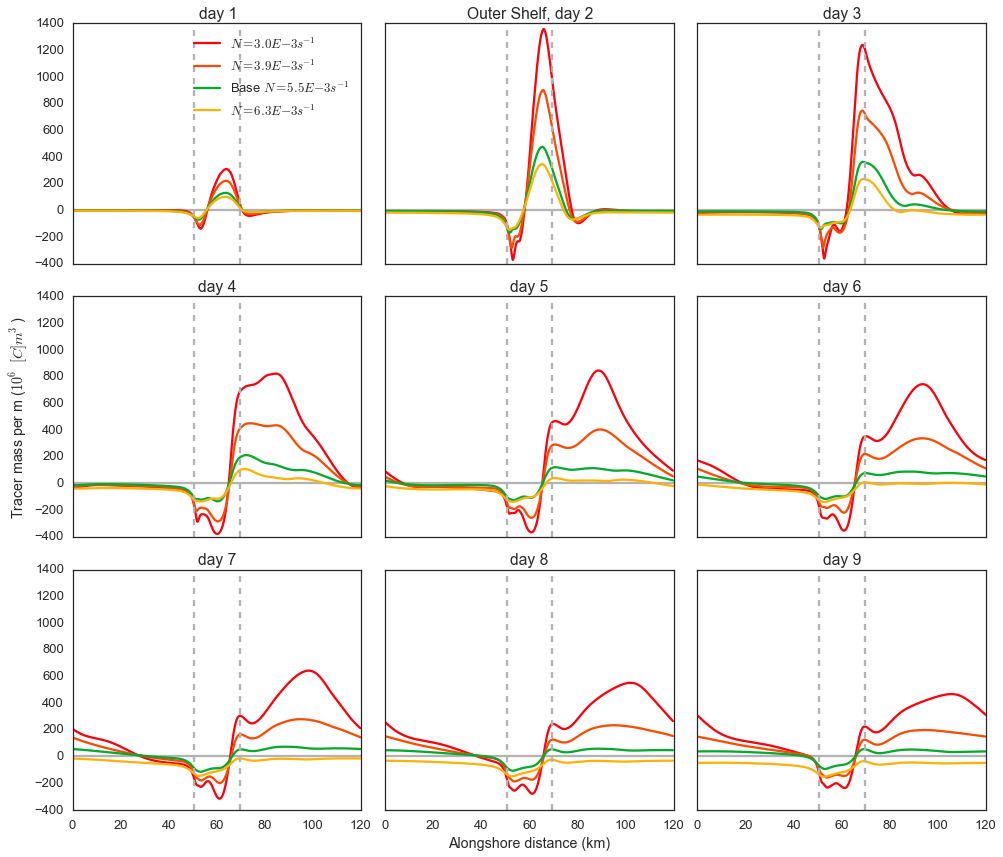

In [53]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3, figsize = (14,12),sharex=True, sharey=True)

axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

times = [2,4,6,8,10,12,14,16,18]
for ii,ax in zip(times,axlist):
    plotZeroLine(ax)
    ax.plot(xc[1,:]/1000,(TrMass16out[ii,:]-TrMass28out[ii,:])/(1000000*dxf[0,:]),sns.xkcd_rgb["bright red"],label='$N=3.0E-3s^{-1}$')
    ax.plot(xc[1,:]/1000,(TrMass14out[ii,:]-TrMass26out[ii,:])/(1000000*dxf[0,:]),sns.xkcd_rgb["blood orange"],label='$N=3.9E-3s^{-1}$')
    ax.plot(xc[1,:]/1000,(TrMassout[ii,:]-TrMassNoCout[ii,:])/(1000000*dxf[0,:]),sns.xkcd_rgb["kelly green"],label='Base $N=5.5E-3s^{-1}$')
    ax.plot(xc[1,:]/1000,(TrMass15out[ii,:]-TrMass25out[ii,:])/(1000000*dxf[0,:]),sns.xkcd_rgb["saffron"],label='$N=6.3E-3s^{-1}$')
   
    
    ax.set_title('day %d' %(ii/2))
    plotCanyonPos(ax,xc[1,120]/1000,xc[1,240]/1000)

ax1.legend(loc=0)
ax8.set_xlabel('Alongshore distance (km)')
ax4.set_ylabel('Tracer mass per m ($10^6$ $[C]m^3$)')
ax2.set_title('Outer Shelf, day 2')

plt.tight_layout()

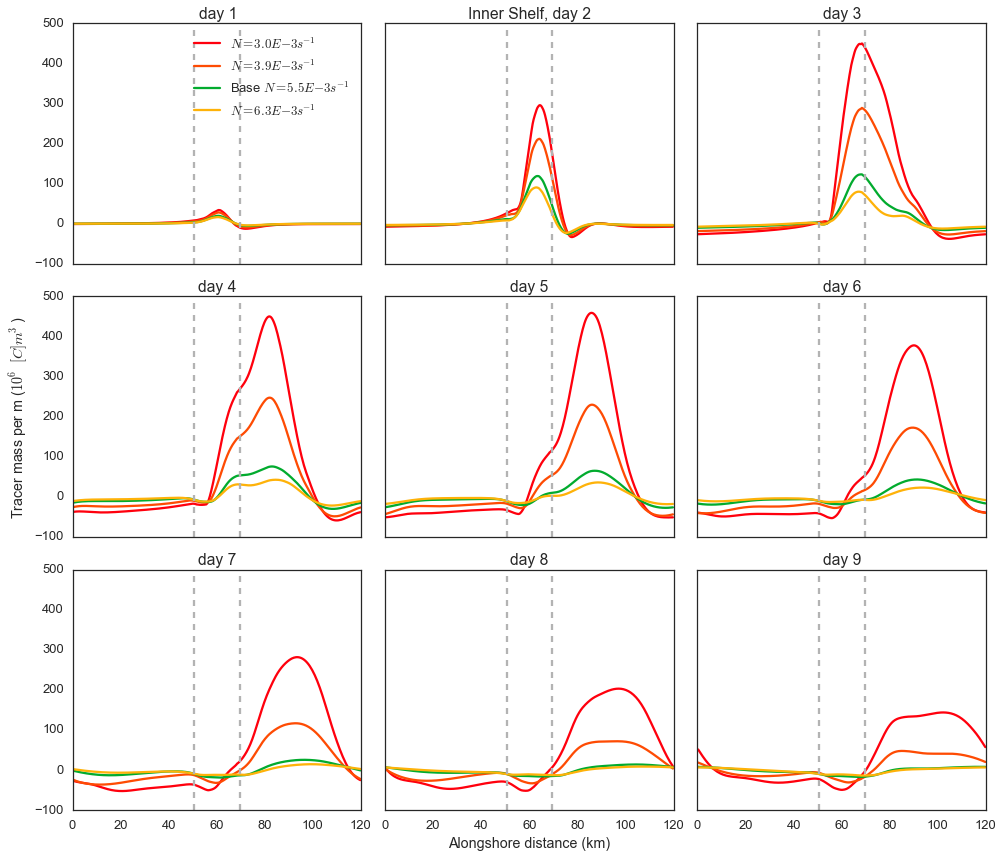

In [54]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3, figsize = (14,12),sharex=True, sharey=True)

axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

times = [2,4,6,8,10,12,14,16,18]
for ii,ax in zip(times,axlist):
    ax.plot(xc[1,:]/1000,(TrMass16in[ii,:]-TrMass28in[ii,:])/(1000000*dxf[0,:]),sns.xkcd_rgb["bright red"],label='$N=3.0E-3s^{-1}$')
    ax.plot(xc[1,:]/1000,(TrMass14in[ii,:]-TrMass26in[ii,:])/(1000000*dxf[0,:]),sns.xkcd_rgb["blood orange"],label='$N=3.9E-3s^{-1}$')
    ax.plot(xc[1,:]/1000,(TrMassin[ii,:]-TrMassNoCin[ii,:])/(1000000*dxf[0,:]),sns.xkcd_rgb["kelly green"],label='Base $N=5.5E-3s^{-1}$')
    ax.plot(xc[1,:]/1000,(TrMass15in[ii,:]-TrMass27in[ii,:])/(1000000*dxf[0,:]),sns.xkcd_rgb["saffron"],label='$N=6.3E-3s^{-1}$')
   
    
    ax.set_title('day %d' %(ii/2))
    plotCanyonPos(ax,xc[1,120]/1000,xc[1,240]/1000)

ax1.legend(loc=0)
ax8.set_xlabel('Alongshore distance (km)')
ax4.set_ylabel('Tracer mass per m ($10^6$ $[C]m^3$)')
ax2.set_title('Inner Shelf, day 2')
plt.tight_layout()

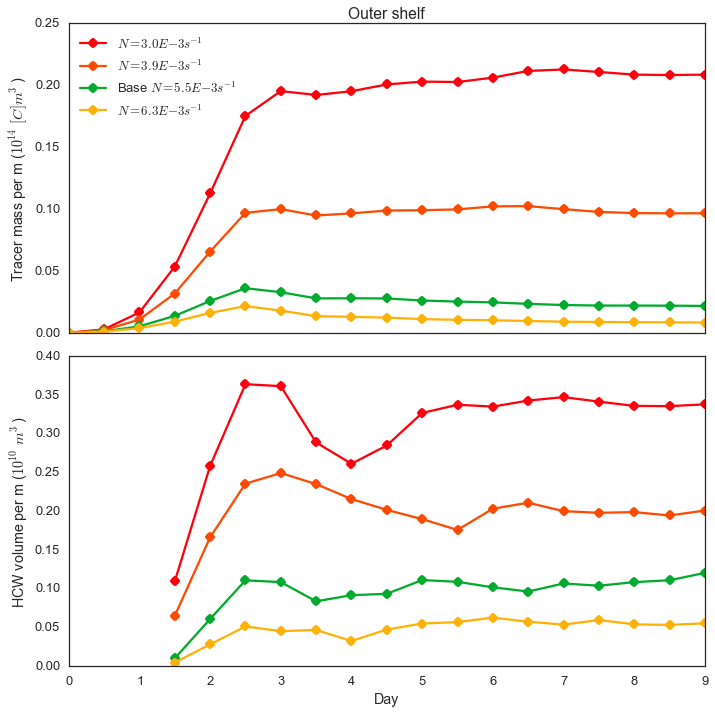

In [55]:
fig,(ax1,ax2) = plt.subplots(2,1, figsize = (10,10),sharex=True)

tt = np.arange(19)

ax1.plot(tt/2.,np.sum(TrMass16out-TrMass28out,axis=1)/1.E14,sns.xkcd_rgb["bright red"],marker = 'o',label='$N=3.0E-3s^{-1}$')
ax1.plot(tt/2.,np.sum(TrMass14out-TrMass26out,axis=1)/1.E14,sns.xkcd_rgb["blood orange"],marker = 'o',label='$N=3.9E-3s^{-1}$')
ax1.plot(tt/2.,np.sum(TrMassout-TrMassNoCout,axis=1)/1.E14,sns.xkcd_rgb["kelly green"],marker = 'o',label='Base $N=5.5E-3s^{-1}$')
ax1.plot(tt/2.,np.sum(TrMass15out-TrMass27out,axis=1)/1.E14,sns.xkcd_rgb["saffron"],marker = 'o',label='$N=6.3E-3s^{-1}$')
   
ax2.plot(tt/2.,np.sum(HCW16out-HCW28out,axis=1)/1.E10,sns.xkcd_rgb["bright red"],marker = 'o',label='$N=3.0E-3s^{-1}$')
ax2.plot(tt/2.,np.sum(HCW14out-HCW26out,axis=1)/1.E10,sns.xkcd_rgb["blood orange"],marker = 'o',label='$N=3.9E-3s^{-1}$')
ax2.plot(tt/2.,np.sum(HCWout-HCWNoCout,axis=1)/1.E10,sns.xkcd_rgb["kelly green"],marker = 'o',label='Base $N=5.5E-3s^{-1}$')
ax2.plot(tt/2.,np.sum(HCW15out-HCW27out,axis=1)/1.E10,sns.xkcd_rgb["saffron"],marker = 'o',label='$N=6.3E-3s^{-1}$')
     
    
ax1.legend(loc=0)
ax2.set_xlabel('Day')
ax1.set_ylabel('Tracer mass per m ($10^{14}$ $[C]m^3$)')
ax2.set_ylabel('HCW volume per m ($10^{10}$ $m^3$)')
ax1.set_title('Outer shelf')
plt.tight_layout()
plt.show()



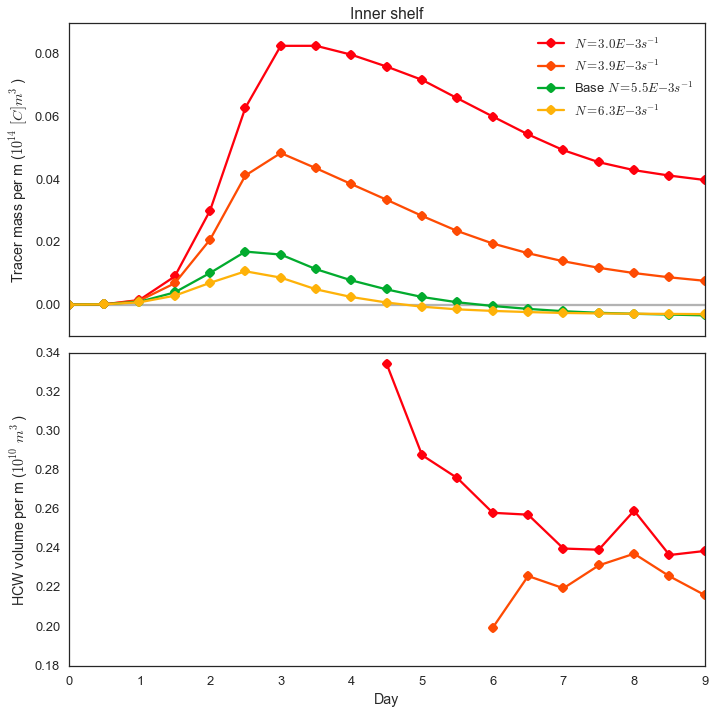

In [75]:
fig,(ax1,ax2) = plt.subplots(2,1, figsize = (10,10),sharex=True)

tt = np.arange(19)
plotZeroLine(ax1)
ax1.plot(tt/2.,np.sum(TrMass16in-TrMass28in,axis=1)/1.E14,sns.xkcd_rgb["bright red"],marker = 'o',label='$N=3.0E-3s^{-1}$')
ax1.plot(tt/2.,np.sum(TrMass14in-TrMass26in,axis=1)/1.E14,sns.xkcd_rgb["blood orange"],marker = 'o',label='$N=3.9E-3s^{-1}$')
ax1.plot(tt/2.,np.sum(TrMassin-TrMassNoCin,axis=1)/1.E14,sns.xkcd_rgb["kelly green"],marker = 'o',label='Base $N=5.5E-3s^{-1}$')
ax1.plot(tt/2.,np.sum(TrMass15in-TrMass27in,axis=1)/1.E14,sns.xkcd_rgb["saffron"],marker = 'o',label='$N=6.3E-3s^{-1}$')
   
ax2.plot(tt/2.,np.sum(HCW16in-HCW28in,axis=1)/1.E10,sns.xkcd_rgb["bright red"],marker = 'o',label='$N=3.0E-3s^{-1}$')
ax2.plot(tt/2.,np.sum(HCW14in-HCW26in,axis=1)/1.E10,sns.xkcd_rgb["blood orange"],marker = 'o',label='$N=3.9E-3s^{-1}$')
ax2.plot(tt/2.,np.sum(HCWin-HCWNoCin,axis=1)/1.E10,sns.xkcd_rgb["kelly green"],marker = 'o',label='Base $N=5.5E-3s^{-1}$')
ax2.plot(tt/2.,np.sum(HCW15in-HCW27in,axis=1)/1.E10,sns.xkcd_rgb["saffron"],marker = 'o',label='$N=6.3E-3s^{-1}$')
     
    
ax1.legend(loc=0)
ax2.set_xlabel('Day')
ax1.set_ylabel('Tracer mass per m ($10^{14}$ $[C]m^3$)')
ax2.set_ylabel('HCW volume per m ($10^{10}$ $m^3$)')
ax1.set_title('Inner shelf')
plt.tight_layout()
plt.show()



## Changing latitude (f)

In [60]:
Tra = rout.getField(Ptracers18, 'Tr1')
Trb = rout.getField(Ptracers19, 'Tr1')
Trc = rout.getField(Ptracers22, 'Tr1')
Trd = rout.getField(Ptracers23, 'Tr1')

In [61]:
HCW18out,TrMass18out = HCW_Tracer_AlongShelf_Split(Tra,mask_NoC,30,rA,hFacC,drF,227,267,30,180,50)
HCW19out,TrMass19out = HCW_Tracer_AlongShelf_Split(Trb,mask_NoC,30,rA,hFacC,drF,227,267,30,180,50)
HCW22out,TrMass22out = HCW_Tracer_AlongShelf_Split(Trc,mask_NoC,30,rA,hFacC,drF,227,267,30,180,50)
HCW23out,TrMass23out = HCW_Tracer_AlongShelf_Split(Trd,mask_NoC,30,rA,hFacC,drF,227,267,30,180,50)

HCW18in,TrMass18in = HCW_Tracer_AlongShelf_Split(Tra,mask_NoC,30,rA,hFacC,drF,267,359,30,180,50)
HCW19in,TrMass19in = HCW_Tracer_AlongShelf_Split(Trb,mask_NoC,30,rA,hFacC,drF,267,359,30,180,50)
HCW22in,TrMass22in = HCW_Tracer_AlongShelf_Split(Trc,mask_NoC,30,rA,hFacC,drF,267,359,30,180,50)
HCW23in,TrMass23in = HCW_Tracer_AlongShelf_Split(Trd,mask_NoC,30,rA,hFacC,drF,267,359,30,180,50)


('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)


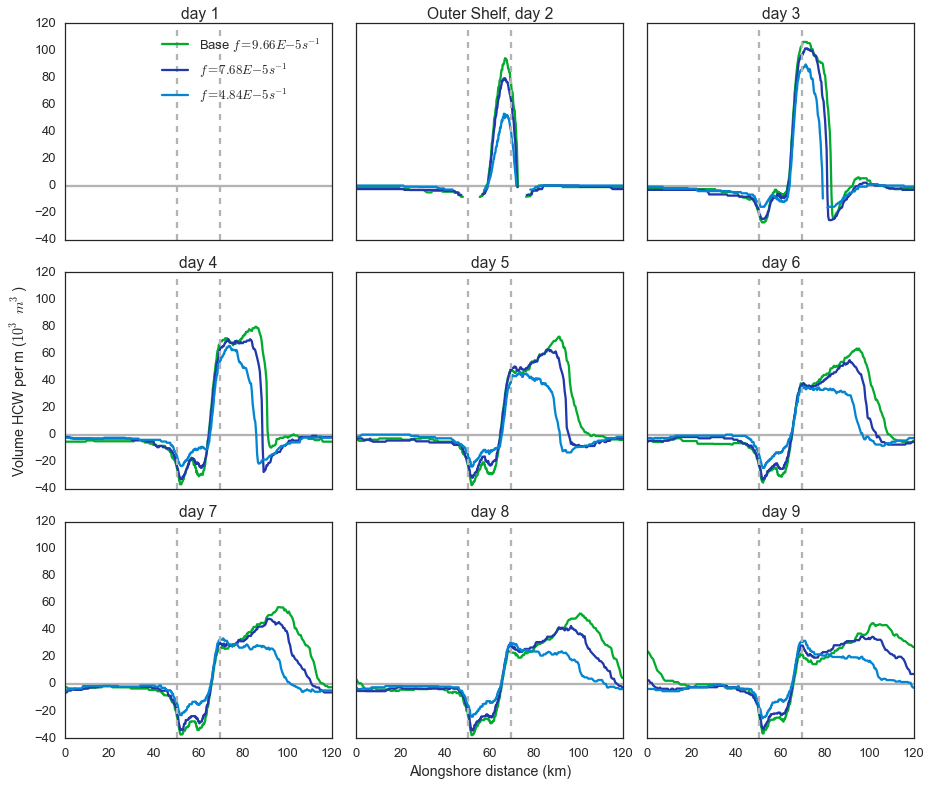

In [63]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3, figsize = (13,11),sharex=True, sharey=True)

axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

times = [2,4,6,8,10,12,14,16,18]
for ii,ax in zip(times,axlist):
    plotZeroLine(ax)
    ax.plot(xc[1,:]/1000,(HCWout[ii,:]-HCWNoCout[ii,:])/(1000*dxf[0,:]),sns.xkcd_rgb["kelly green"],label='Base $f=9.66E-5s^{-1}$')
    ax.plot(xc[1,:]/1000,(HCW18out[ii,:]-HCW22out[ii,:])/(1000*dxf[0,:]),sns.xkcd_rgb["sapphire"],label='$f=7.68E-5s^{-1}$')
    ax.plot(xc[1,:]/1000,(HCW19out[ii,:]-HCW23out[ii,:])/(1000*dxf[0,:]),sns.xkcd_rgb["cerulean"],label='$f=4.84E-5s^{-1}$')
    
    
    ax.set_title('day %d' %(ii/2))
    plotCanyonPos(ax,xc[1,120]/1000,xc[1,240]/1000)

ax1.legend(loc=0)
ax8.set_xlabel('Alongshore distance (km)')
ax4.set_ylabel('Volume HCW per m ($10^3$ $m^3$)')
ax2.set_title('Outer Shelf, day 2')
plt.tight_layout()

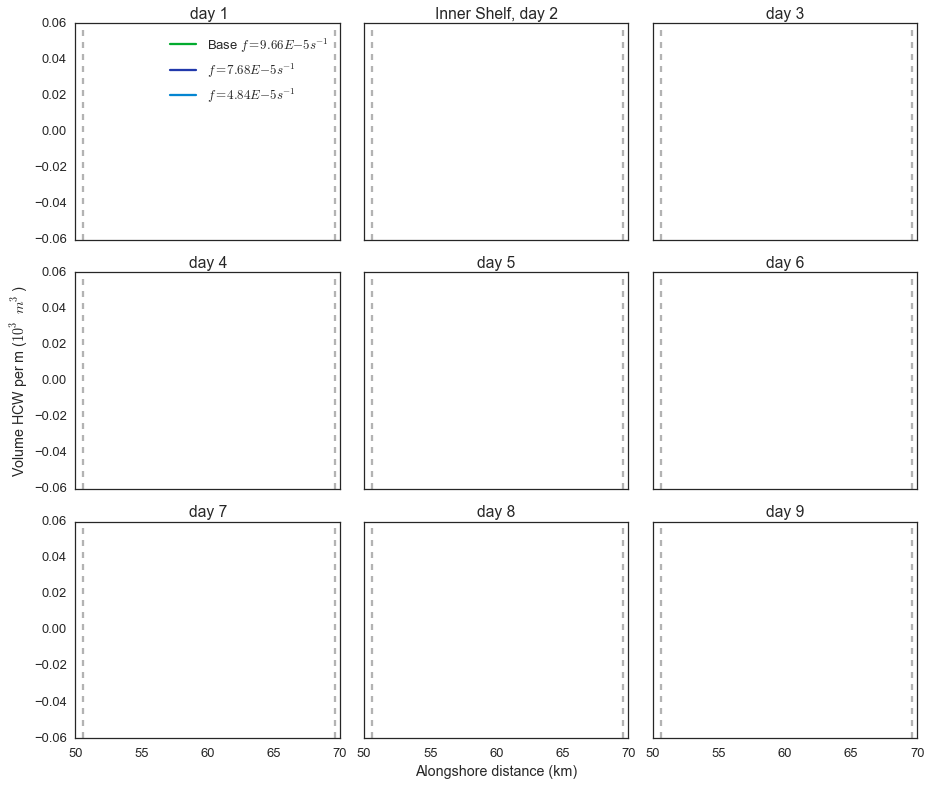

In [68]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3, figsize = (13,11),sharex=True, sharey=True)

axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

times = [2,4,6,8,10,12,14,16,18]
for ii,ax in zip(times,axlist):
    
    ax.plot(xc[1,:]/1000,(HCWin[ii,:]-HCWNoCin[ii,:])/(1000*dxf[0,:]),sns.xkcd_rgb["kelly green"],label='Base $f=9.66E-5s^{-1}$')
    ax.plot(xc[1,:]/1000,(HCW18in[ii,:]-HCW22in[ii,:])/(1000*dxf[0,:]),sns.xkcd_rgb["sapphire"],label='$f=7.68E-5s^{-1}$')
    ax.plot(xc[1,:]/1000,(HCW19in[ii,:]-HCW23in[ii,:])/(1000*dxf[0,:]),sns.xkcd_rgb["cerulean"],label='$f=4.84E-5s^{-1}$')
    
    
    ax.set_title('day %d' %(ii/2))
    plotCanyonPos(ax,xc[1,120]/1000,xc[1,240]/1000)

ax1.legend(loc=0)
ax8.set_xlabel('Alongshore distance (km)')
ax4.set_ylabel('Volume HCW per m ($10^3$ $m^3$)')
ax2.set_title('Inner Shelf, day 2')
plt.tight_layout()

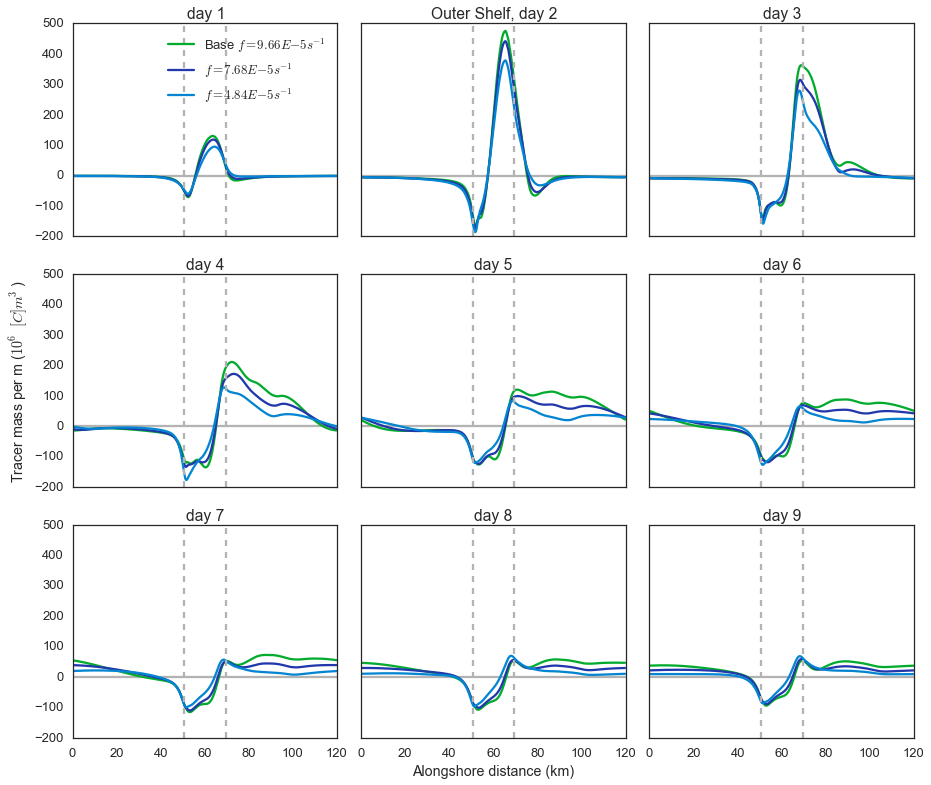

In [69]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3, figsize = (13,11),sharex=True, sharey=True)

axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

times = [2,4,6,8,10,12,14,16,18]
for ii,ax in zip(times,axlist):
    plotZeroLine(ax)
    ax.plot(xc[1,:]/1000,(TrMassout[ii,:]-TrMassNoCout[ii,:])/(1000000*dxf[0,:]),sns.xkcd_rgb["kelly green"],label='Base $f=9.66E-5s^{-1}$')
    ax.plot(xc[1,:]/1000,(TrMass18out[ii,:]-TrMass22out[ii,:])/(1000000*dxf[0,:]),sns.xkcd_rgb["sapphire"],label='$f=7.68E-5s^{-1}$')
    ax.plot(xc[1,:]/1000,(TrMass19out[ii,:]-TrMass23out[ii,:])/(1000000*dxf[0,:]),sns.xkcd_rgb["cerulean"],label='$f=4.84E-5s^{-1}$')
    
    
    ax.set_title('day %d' %(ii/2))
    plotCanyonPos(ax,xc[1,120]/1000,xc[1,240]/1000)

ax1.legend(loc=0)
ax8.set_xlabel('Alongshore distance (km)')
ax4.set_ylabel('Tracer mass per m ($10^6$ $[C]m^3$)')
ax2.set_title('Outer Shelf, day 2')

plt.tight_layout()

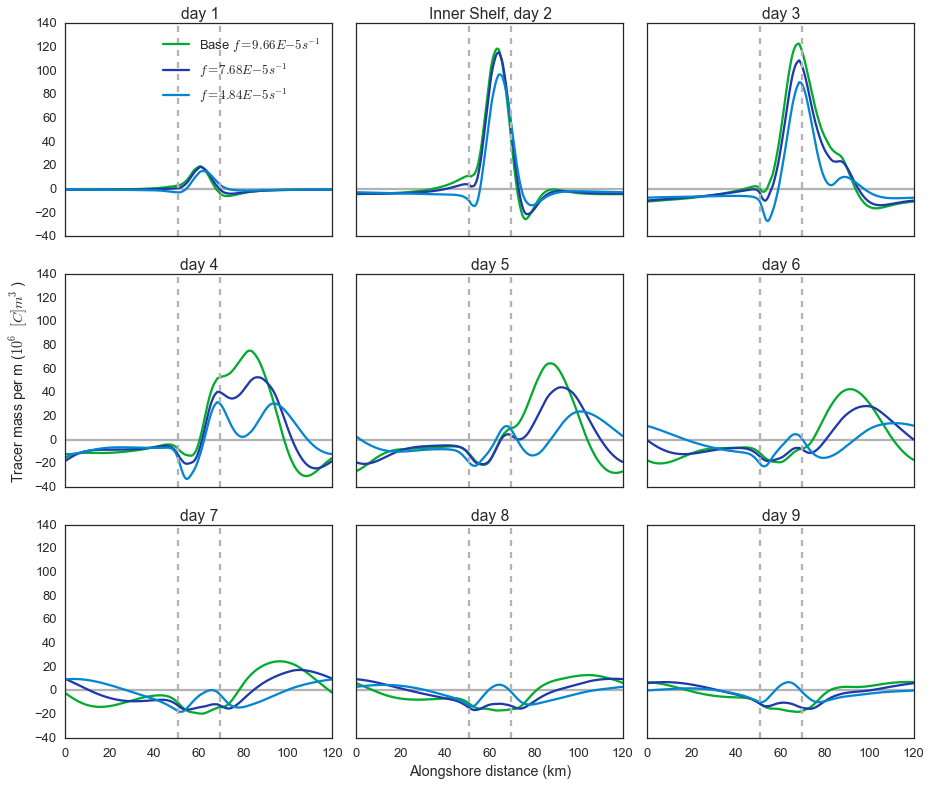

In [70]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3,3, figsize = (13,11),sharex=True, sharey=True)

axlist = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]

times = [2,4,6,8,10,12,14,16,18]
for ii,ax in zip(times,axlist):
    plotZeroLine(ax)
    ax.plot(xc[1,:]/1000,(TrMassin[ii,:]-TrMassNoCin[ii,:])/(1000000*dxf[0,:]),sns.xkcd_rgb["kelly green"],label='Base $f=9.66E-5s^{-1}$')
    ax.plot(xc[1,:]/1000,(TrMass18in[ii,:]-TrMass22in[ii,:])/(1000000*dxf[0,:]),sns.xkcd_rgb["sapphire"],label='$f=7.68E-5s^{-1}$')
    ax.plot(xc[1,:]/1000,(TrMass19in[ii,:]-TrMass23in[ii,:])/(1000000*dxf[0,:]),sns.xkcd_rgb["cerulean"],label='$f=4.84E-5s^{-1}$')
    
    
    ax.set_title('day %d' %(ii/2))
    plotCanyonPos(ax,xc[1,120]/1000,xc[1,240]/1000)

ax1.legend(loc=0)
ax8.set_xlabel('Alongshore distance (km)')
ax4.set_ylabel('Tracer mass per m ($10^6$ $[C]m^3$)')
ax2.set_title('Inner Shelf, day 2')

plt.tight_layout()

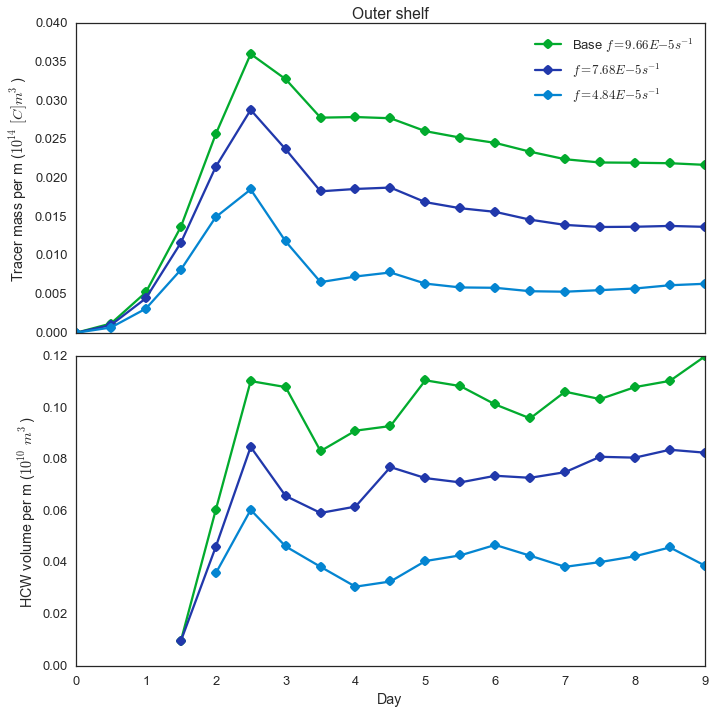

In [71]:
fig,(ax1,ax2) = plt.subplots(2,1, figsize = (10,10),sharex=True)

tt = np.arange(19)

ax2.plot(tt/2.,np.sum(HCWout-HCWNoCout,axis=1)/1.E10,sns.xkcd_rgb["kelly green"],marker='o',label='Base $f=9.66E-5s^{-1}$')
ax2.plot(tt/2.,np.sum(HCW18out-HCW22out,axis=1)/1.E10,sns.xkcd_rgb["sapphire"],marker='o',label='$f=7.68E-5s^{-1}$')
ax2.plot(tt/2.,np.sum(HCW19out-HCW23out,axis=1)/1.E10,sns.xkcd_rgb["cerulean"],marker='o',label='f=4.84E-5s^{-1}$')
 
ax1.plot(tt/2.,np.sum(TrMassout-TrMassNoCout,axis=1)/1.E14,sns.xkcd_rgb["kelly green"],marker='o',label='Base $f=9.66E-5s^{-1}$')
ax1.plot(tt/2.,np.sum(TrMass18out-TrMass22out,axis=1)/1.E14,sns.xkcd_rgb["sapphire"],marker='o',label='$f=7.68E-5s^{-1}$')
ax1.plot(tt/2.,np.sum(TrMass19out-TrMass23out,axis=1)/1.E14,sns.xkcd_rgb["cerulean"],marker='o',label='$f=4.84E-5s^{-1}$')
        
ax1.set_title('Outer shelf')   
ax1.legend(loc=0)
ax2.set_xlabel('Day')
ax1.set_ylabel('Tracer mass per m ($10^{14}$ $[C]m^3$)')
ax2.set_ylabel('HCW volume per m ($10^{10}$ $m^3$)')

plt.tight_layout()
plt.show()



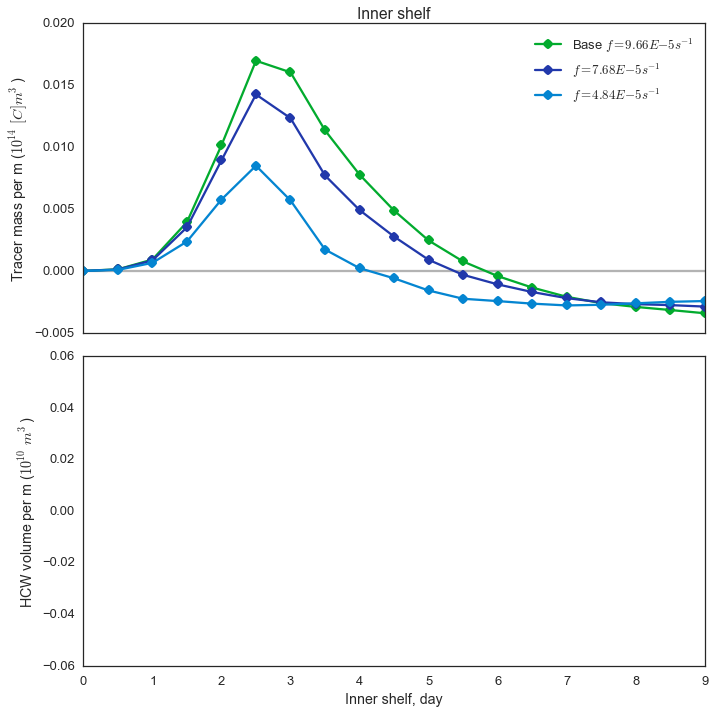

In [74]:
fig,(ax1,ax2) = plt.subplots(2,1, figsize = (10,10),sharex=True)

tt = np.arange(19)
plotZeroLine(ax1)
ax2.plot(tt/2.,np.sum(HCWin-HCWNoCin,axis=1)/1.E10,sns.xkcd_rgb["kelly green"],marker='o',label='Base $f=9.66E-5s^{-1}$')
ax2.plot(tt/2.,np.sum(HCW18in-HCW22in,axis=1)/1.E10,sns.xkcd_rgb["sapphire"],marker='o',label='$f=7.68E-5s^{-1}$')
ax2.plot(tt/2.,np.sum(HCW19in-HCW23in,axis=1)/1.E10,sns.xkcd_rgb["cerulean"],marker='o',label='f=4.84E-5s^{-1}$')
 
ax1.plot(tt/2.,np.sum(TrMassin-TrMassNoCin,axis=1)/1.E14,sns.xkcd_rgb["kelly green"],marker='o',label='Base $f=9.66E-5s^{-1}$')
ax1.plot(tt/2.,np.sum(TrMass18in-TrMass22in,axis=1)/1.E14,sns.xkcd_rgb["sapphire"],marker='o',label='$f=7.68E-5s^{-1}$')
ax1.plot(tt/2.,np.sum(TrMass19in-TrMass23in,axis=1)/1.E14,sns.xkcd_rgb["cerulean"],marker='o',label='$f=4.84E-5s^{-1}$')
        
ax1.set_title('Inner shelf')     
ax1.legend(loc=0)
ax2.set_xlabel('Inner shelf, day')
ax1.set_ylabel('Tracer mass per m ($10^{14}$ $[C]m^3$)')
ax2.set_ylabel('HCW volume per m ($10^{10}$ $m^3$)')
plt.tight_layout()
plt.show()



### Process the rest of the runs and save dataframe


In [98]:
# Process the rest of the runs to save pandas dataframe
Ptracers02 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run02/ptracersGlob.nc' 
Ptracers04 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run04/ptracersGlob.nc' 
Ptracers20 = '/ocean/kramosmu/MITgcm/TracerExperiments/CNTDIFF/run20/ptracersGlob.nc' 

Tra = rout.getField(Ptracers02, 'Tr1')
Trb = rout.getField(Ptracers04, 'Tr1')
Trc = rout.getField(Ptracers20, 'Tr2')

HCW02out,TrMass02out = HCW_Tracer_AlongShelf_Split(Tra,mask_NoC,30,rA,hFacC,drF,227,267,30,180,50)
HCW04out,TrMass04out = HCW_Tracer_AlongShelf_Split(Trb,mask_NoC,30,rA,hFacC,drF,227,267,30,180,50)
HCW20out,TrMass20out = HCW_Tracer_AlongShelf_Split(Trc,mask_NoC,30,rA,hFacC,drF,227,267,30,180,50)

HCW02in,TrMass02in = HCW_Tracer_AlongShelf_Split(Tra,mask_NoC,30,rA,hFacC,drF,267,359,30,180,50)
HCW04in,TrMass04in = HCW_Tracer_AlongShelf_Split(Trb,mask_NoC,30,rA,hFacC,drF,267,359,30,180,50)
HCW20in,TrMass20in = HCW_Tracer_AlongShelf_Split(Trc,mask_NoC,30,rA,hFacC,drF,267,359,30,180,50)


('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)
('tracer limit concentration is: ', 7.3974895)


In [99]:
runs = ['02','03','04','07','11','12','14','15','16','17','18','19','20','043D','053D','063D','073D']

DHCW_dataOut = np.zeros(len(runs))
DTrMass_dataOut = np.zeros(len(runs))
# HCW
DHCW_dataOut[0] = ((np.sum(HCW02out,axis=1)[18]-np.sum(HCW02out,axis=1)[10])/(4*3600.0*24))
DHCW_dataOut[1] = ((np.sum(HCWout,axis=1)[18]-np.sum(HCWout,axis=1)[10])/(4*3600.0*24))
DHCW_dataOut[2] = ((np.sum(HCW04out,axis=1)[18]-np.sum(HCW04out,axis=1)[10])/(4*3600.0*24))
DHCW_dataOut[3] = ((np.sum(HCWNoCout,axis=1)[18]-np.sum(HCWNoCout,axis=1)[10])/(4*3600.0*24))
DHCW_dataOut[4] = ((np.sum(HCW11out,axis=1)[18]-np.sum(HCW11out,axis=1)[10])/(4*3600.0*24))
DHCW_dataOut[5] = ((np.sum(HCW12out,axis=1)[18]-np.sum(HCW12out,axis=1)[10])/(4*3600.0*24))
DHCW_dataOut[6] = ((np.sum(HCW14out,axis=1)[18]-np.sum(HCW14out,axis=1)[10])/(4*3600.0*24))
DHCW_dataOut[7] = ((np.sum(HCW15out,axis=1)[18]-np.sum(HCW15out,axis=1)[10])/(4*3600.0*24))
DHCW_dataOut[8] = ((np.sum(HCW16out,axis=1)[18]-np.sum(HCW16out,axis=1)[10])/(4*3600.0*24))
DHCW_dataOut[9] = ((np.sum(HCW17out,axis=1)[18]-np.sum(HCW17out,axis=1)[10])/(4*3600.0*24))
DHCW_dataOut[10] = ((np.sum(HCW18out,axis=1)[18]-np.sum(HCW18out,axis=1)[10])/(4*3600.0*24))
DHCW_dataOut[11] = ((np.sum(HCW19out,axis=1)[18]-np.sum(HCW19out,axis=1)[10])/(4*3600.0*24))
DHCW_dataOut[12] = ((np.sum(HCW20out,axis=1)[18]-np.sum(HCW20out,axis=1)[10])/(4*3600.0*24))

DHCW_dataOut[13] = ((np.sum(HCW043Dout,axis=1)[18]-np.sum(HCW043Dout,axis=1)[10])/(4*3600.0*24))
DHCW_dataOut[14] = ((np.sum(HCW053Dout,axis=1)[18]-np.sum(HCW053Dout,axis=1)[10])/(4*3600.0*24))
DHCW_dataOut[15] = ((np.sum(HCW063Dout,axis=1)[18]-np.sum(HCW063Dout,axis=1)[10])/(4*3600.0*24))
DHCW_dataOut[16] = ((np.sum(HCW073Dout,axis=1)[18]-np.sum(HCW073Dout,axis=1)[10])/(4*3600.0*24))

 

#Tracer mass
DTrMass_dataOut[0] = ((np.sum(TrMass02out,axis=1)[18]-np.sum(TrMass02out,axis=1)[10])/(4*3600.0*24))
DTrMass_dataOut[1] =((np.sum(TrMassout,axis=1)[18]-np.sum(TrMassout,axis=1)[10])/(4*3600.0*24))
DTrMass_dataOut[2] =((np.sum(TrMass04out,axis=1)[18]-np.sum(TrMass04out,axis=1)[10])/(4*3600.0*24))
DTrMass_dataOut[3] =((np.sum(TrMassNoCout,axis=1)[18]-np.sum(TrMassNoCout,axis=1)[10])/(4*3600.0*24))
DTrMass_dataOut[4] =((np.sum(TrMass11out,axis=1)[18]-np.sum(TrMass11out,axis=1)[10])/(4*3600.0*24))
DTrMass_dataOut[5] =((np.sum(TrMass12out,axis=1)[18]-np.sum(TrMass12out,axis=1)[10])/(4*3600.0*24))
DTrMass_dataOut[6] =((np.sum(TrMass14out,axis=1)[18]-np.sum(TrMass14out,axis=1)[10])/(4*3600.0*24))
DTrMass_dataOut[7] =((np.sum(TrMass15out,axis=1)[18]-np.sum(TrMass15out,axis=1)[10])/(4*3600.0*24))
DTrMass_dataOut[8] =((np.sum(TrMass16out,axis=1)[18]-np.sum(TrMass16out,axis=1)[10])/(4*3600.0*24))
DTrMass_dataOut[9] =((np.sum(TrMass17out,axis=1)[18]-np.sum(TrMass17out,axis=1)[10])/(4*3600.0*24))
DTrMass_dataOut[10] =((np.sum(TrMass18out,axis=1)[18]-np.sum(TrMass18out,axis=1)[10])/(4*3600.0*24))
DTrMass_dataOut[11] =((np.sum(TrMass19out,axis=1)[18]-np.sum(TrMass19out,axis=1)[10])/(4*3600.0*24))
DTrMass_dataOut[12] =((np.sum(TrMass20out,axis=1)[18]-np.sum(TrMass20out,axis=1)[10])/(4*3600.0*24))

 
DTrMass_dataOut[13] =((np.sum(TrMass043Dout,axis=1)[18]-np.sum(TrMass043Dout,axis=1)[10])/(4*3600.0*24))
DTrMass_dataOut[14] =((np.sum(TrMass053Dout,axis=1)[18]-np.sum(TrMass053Dout,axis=1)[10])/(4*3600.0*24))
DTrMass_dataOut[15] =((np.sum(TrMass063Dout,axis=1)[18]-np.sum(TrMass063Dout,axis=1)[10])/(4*3600.0*24))
DTrMass_dataOut[16] =((np.sum(TrMass073Dout,axis=1)[18]-np.sum(TrMass073Dout,axis=1)[10])/(4*3600.0*24))

In [100]:
runs = ['02','03','04','07','11','12','14','15','16','17','18','19','20','043D','053D','063D','073D']

DHCW_dataIn = np.zeros(len(runs))
DTrMass_dataIn = np.zeros(len(runs))
# HCW
DHCW_dataIn[0] = ((np.sum(HCW02in,axis=1)[18]-np.sum(HCW02in,axis=1)[10])/(4*3600.0*24))
DHCW_dataIn[1] = ((np.sum(HCWin,axis=1)[18]-np.sum(HCWin,axis=1)[10])/(4*3600.0*24))
DHCW_dataIn[2] = ((np.sum(HCW04in,axis=1)[18]-np.sum(HCW04in,axis=1)[10])/(4*3600.0*24))
DHCW_dataIn[3] = ((np.sum(HCWNoCin,axis=1)[18]-np.sum(HCWNoCin,axis=1)[10])/(4*3600.0*24))
DHCW_dataIn[4] = ((np.sum(HCW11in,axis=1)[18]-np.sum(HCW11in,axis=1)[10])/(4*3600.0*24))
DHCW_dataIn[5] = ((np.sum(HCW12in,axis=1)[18]-np.sum(HCW12in,axis=1)[10])/(4*3600.0*24))
DHCW_dataIn[6] = ((np.sum(HCW14in,axis=1)[18]-np.sum(HCW14in,axis=1)[10])/(4*3600.0*24))
DHCW_dataIn[7] = ((np.sum(HCW15in,axis=1)[18]-np.sum(HCW15in,axis=1)[10])/(4*3600.0*24))
DHCW_dataIn[8] = ((np.sum(HCW16in,axis=1)[18]-np.sum(HCW16in,axis=1)[10])/(4*3600.0*24))
DHCW_dataIn[9] = ((np.sum(HCW17in,axis=1)[18]-np.sum(HCW17in,axis=1)[10])/(4*3600.0*24))
DHCW_dataIn[10] = ((np.sum(HCW18in,axis=1)[18]-np.sum(HCW18in,axis=1)[10])/(4*3600.0*24))
DHCW_dataIn[11] = ((np.sum(HCW19in,axis=1)[18]-np.sum(HCW19in,axis=1)[10])/(4*3600.0*24))
DHCW_dataIn[12] = ((np.sum(HCW20in,axis=1)[18]-np.sum(HCW20in,axis=1)[10])/(4*3600.0*24))

DHCW_dataIn[13] = ((np.sum(HCW043Din,axis=1)[18]-np.sum(HCW043Din,axis=1)[10])/(4*3600.0*24))
DHCW_dataIn[14] = ((np.sum(HCW053Din,axis=1)[18]-np.sum(HCW053Din,axis=1)[10])/(4*3600.0*24))
DHCW_dataIn[15] = ((np.sum(HCW063Din,axis=1)[18]-np.sum(HCW063Din,axis=1)[10])/(4*3600.0*24))
DHCW_dataIn[16] = ((np.sum(HCW073Din,axis=1)[18]-np.sum(HCW073Din,axis=1)[10])/(4*3600.0*24))

 

#Tracer mass
DTrMass_dataIn[0] = ((np.sum(TrMass02in,axis=1)[18]-np.sum(TrMass02in,axis=1)[10])/(4*3600.0*24))
DTrMass_dataIn[1] =((np.sum(TrMassin,axis=1)[18]-np.sum(TrMassin,axis=1)[10])/(4*3600.0*24))
DTrMass_dataIn[2] =((np.sum(TrMass04in,axis=1)[18]-np.sum(TrMass04in,axis=1)[10])/(4*3600.0*24))
DTrMass_dataIn[3] =((np.sum(TrMassNoCin,axis=1)[18]-np.sum(TrMassNoCin,axis=1)[10])/(4*3600.0*24))
DTrMass_dataIn[4] =((np.sum(TrMass11in,axis=1)[18]-np.sum(TrMass11in,axis=1)[10])/(4*3600.0*24))
DTrMass_dataIn[5] =((np.sum(TrMass12in,axis=1)[18]-np.sum(TrMass12in,axis=1)[10])/(4*3600.0*24))
DTrMass_dataIn[6] =((np.sum(TrMass14in,axis=1)[18]-np.sum(TrMass14in,axis=1)[10])/(4*3600.0*24))
DTrMass_dataIn[7] =((np.sum(TrMass15in,axis=1)[18]-np.sum(TrMass15in,axis=1)[10])/(4*3600.0*24))
DTrMass_dataIn[8] =((np.sum(TrMass16in,axis=1)[18]-np.sum(TrMass16in,axis=1)[10])/(4*3600.0*24))
DTrMass_dataIn[9] =((np.sum(TrMass17in,axis=1)[18]-np.sum(TrMass17in,axis=1)[10])/(4*3600.0*24))
DTrMass_dataIn[10] =((np.sum(TrMass18in,axis=1)[18]-np.sum(TrMass18in,axis=1)[10])/(4*3600.0*24))
DTrMass_dataIn[11] =((np.sum(TrMass19in,axis=1)[18]-np.sum(TrMass19in,axis=1)[10])/(4*3600.0*24))
DTrMass_dataIn[12] =((np.sum(TrMass20in,axis=1)[18]-np.sum(TrMass20in,axis=1)[10])/(4*3600.0*24))

 
DTrMass_dataIn[13] =((np.sum(TrMass043Din,axis=1)[18]-np.sum(TrMass043Din,axis=1)[10])/(4*3600.0*24))
DTrMass_dataIn[14] =((np.sum(TrMass053Din,axis=1)[18]-np.sum(TrMass053Din,axis=1)[10])/(4*3600.0*24))
DTrMass_dataIn[15] =((np.sum(TrMass063Din,axis=1)[18]-np.sum(TrMass063Din,axis=1)[10])/(4*3600.0*24))
DTrMass_dataIn[16] =((np.sum(TrMass073Din,axis=1)[18]-np.sum(TrMass073Din,axis=1)[10])/(4*3600.0*24))

In [101]:
# save data frame
raw_data = {'RunNum':runs,'deltaHCW_Out': DHCW_dataOut,'deltaTrMass_Out': DTrMass_dataOut,'deltaHCW_In': DHCW_dataIn,
            'deltaTrMass_In': DTrMass_dataIn}

df = pd.DataFrame(raw_data, columns = ['eRunNum','deltaHCW_Out','deltaTrMass_Out','deltaHCW_In','deltaTrMass_In'])

filename = ('results/metricsDataFrames/DeltaTrInOutShelf.csv' )
df.to_csv(filename)